<a href="https://colab.research.google.com/github/afvallejo/AD_2023/blob/main/3_Integration_norm_annotattion_AD_CDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load packages

In [ ]:
pip install cellrank bbknn rpy2==3.3.2 anndata2ri leidenalg plotnine colorcet squidpy scplot scanpy gprofiler-official

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /content

/content


In [ ]:
!mkdir MyDrive  
!mount --bind /gdrive/My\ Drive /content/MyDrive

In [ ]:
pip install --ignore-installed cellrank

In [ ]:
pathlib setuptools

In [ ]:
pip install plotnine


In [ ]:
pip install colorcet

In [ ]:
pip install anndata2ri

In [ ]:
"""Functions for downstream work with outputs of remove-background."""

import tables
import numpy as np
import scipy as sp
from typing import Dict
import scanpy as sc

# numpy et al.
import numpy as np
import sys

#import scipy as sp
#import scipy.sparse as sp

import pandas as pd
import gc
import bbknn
import loompy as lp
import squidpy as sqp

from anndata import AnnData


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    try:
        import anndata
    except ImportError:
        raise ImportError('The anndata package must be installed to use the '
                          'function anndata_from_h5()')

    d = dict_from_h5(file)
    X = sp.sparse.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    if analyzed_barcodes_only:
        if 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the count matrix.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)})
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # Add other information to the adata object in the appropriate slot.
    for key, value in d.items():
        try:
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == X.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == X.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass

    return adata


def load_anndata_from_input_and_output(input_file: str,
                                       output_file: str,
                                       analyzed_barcodes_only: bool = True,
                                       input_layer_key: str = 'cellranger') -> 'anndata.AnnData':
    """Load remove-background output count matrix into an anndata object,
    together with remove-background metadata and the raw input counts.

    Args:
        input_file: Raw h5 file used as input for remove-background.
        output_file: Output h5 file created by remove-background (can be
            filtered or not).
        analyzed_barcodes_only: Argument passed to anndata_from_h5().
            False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.
        input_layer_key: Key of the anndata.layer that is created for the raw
            input count matrix.

    Return:
        adata_out: AnnData object with counts before and after remove-background,
            as well as inferred latent variables from remove-background.

    """

    # Load input data.
    adata_raw = anndata_from_h5(input_file, analyzed_barcodes_only=False)

    # Load remove-background output data.
    adata_out = anndata_from_h5(output_file, analyzed_barcodes_only=analyzed_barcodes_only)

    # Subset the raw dataset to the relevant barcodes.
    adata_raw = adata_raw[adata_out.obs.index]

    # Put count matrices into 'layers' in anndata for clarity.
    adata_out.layers[input_layer_key] = adata_raw.X.copy()
    adata_out.layers['cellbender'] = adata_out.X.copy()

    # Pre-compute a bit of metadata.
    adata_out.var['n_cellranger'] = np.array(adata_out.layers['cellranger'].sum(axis=0)).squeeze()
    adata_out.var['n_cellbender'] = np.array(adata_out.layers['cellbender'].sum(axis=0)).squeeze()

    return adata_out

In [ ]:
import scanpy as sc

# numpy et al.
import numpy as np
import sys

#import scipy as sp
#import scipy.sparse as sp

import pandas as pd
import gc
import bbknn
import loompy as lp
import squidpy as sqp

from anndata import AnnData



# R integration
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector, FloatVector, ListVector
import rpy2.robjects as ro
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri, numpy2ri, r
import scrublet as scr
#import scvelo as scv
import scanpy.external as sce
import scipy as sp
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import rcParams
import cellrank as cr
import seaborn as sb
import re
import datetime, time
#sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
#sc.logging.print_version_and_date()

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
%load_ext rpy2.ipython


# add extra code to the path
import sys
sys.path.append('/home/jupyter/bucket/sctoolkit/sctoolkit')
from sctransform import sctransform
from proportions import *


from matplotlib import colors
pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')

import colorcet as cc
import matplotlib.pyplot as pl

#import scipy as sp
import scplot as scp
import holoviews as hv

def _render(self, **kw):
  hv.extension('bokeh')
  return hv.Store.render(self)
hv.core.Dimensioned._repr_mimebundle_ = _render

import scipy as sp

cr.logging.print_versions()

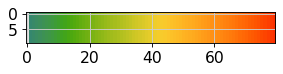

In [ ]:

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [ ]:
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 12})

In [ ]:
import scipy as sp
anndata2ri.activate()

# Setup

In [ ]:
%cd /home/jupyter/bucket/AD_Dropseq/cellbender/

/home/jupyter/bucket/AD_Dropseq/cellbender


In [ ]:
%cd /content/MyDrive/CDS

/content/MyDrive/CDS


In [ ]:
folder='/home/jupyter/bucket/AD_Dropseq/cellbender/'
#folder='/home/jupyter/bucket/20200519_DC_LPS_Dropseq/RNA_velocity/'

samplename='DS'

import os
os.chdir(folder)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

random_state = 42
metric = "euclidean"
# Filtering criteria
flavor="cell_ranger"
n_top_genes = 3000
BBKNN="False"
n_neighbors = 10
#PCA
n_comps=50
#neighbors
num_PCA = 30
n_pcs=30
resolution=0.5

# Load the data

In [ ]:
adata=anndata_from_h5('/content/MyDrive/CDS/AD26C/counts_unfiltered/cellbender1_filtered.h5',analyzed_barcodes_only = True)
adata

AnnData object with n_obs × n_vars = 4386 × 60671
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale'
    var: 'ambient_expression'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [ ]:

metadata = pd.read_csv('/content/metadata_CDS.csv', sep = ',', index_col = 0)
metadata.columns = [ 'Result', 'Group']
metadata.head()

,Result,Group
sample,,
AD26C,R,CR
AD26H,R,HR
AD27C,R,CR
AD27H,R,HR
AD28C,T,TC


In [ ]:
path = '/content/MyDrive/CDS/'
filenames = metadata.index
adatas = [anndata_from_h5(path + filename + '/counts_unfiltered/cellbender2_filtered.h5') for filename in filenames]
for i in range(len(adatas)):
    adatas[i].obs['sample'] = metadata.index[i]
    for col in metadata.columns:
        adatas[i].obs[col] = metadata[col][i]
adata_1 = adatas[0].concatenate(adatas[1:], batch_categories = metadata.index)
adata_1.shape

(29648, 60671)

In [ ]:
adata_1.

,latent_RT_efficiency,latent_cell_probability,latent_scale,sample,Result,Group,batch
barcode,,,,,,,
ATGCTTGTTGAC-AD26C,3.074501,0.999945,1982.676758,AD26C,R,CR,AD26C
CCGGAGCTACGA-AD26C,3.097606,0.999944,1896.658081,AD26C,R,CR,AD26C
TGATTTTACCAC-AD26C,3.092037,0.999930,1916.833008,AD26C,R,CR,AD26C
CCGGGCGGCTTG-AD26C,2.899775,0.999951,2190.837158,AD26C,R,CR,AD26C
CTCTAGGGAGAG-AD26C,3.105264,0.999937,1789.303223,AD26C,R,CR,AD26C
...,...,...,...,...,...,...,...
CCCTATGTTGGT-AD28H,0.588561,0.923922,1113.532959,AD28H,T,TH,AD28H
CGCCATATTAGC-AD28H,0.540465,0.869808,1214.224609,AD28H,T,TH,AD28H
CAAAAGGAAATG-AD28H,0.484435,0.553833,2429.394287,AD28H,T,TH,AD28H


In [ ]:
print(adata_1.obs['sample'].value_counts())

AD27C    6743
AD28H    5306
AD27H    4706
AD26C    4438
AD26H    4392
AD28C    4063
Name: sample, dtype: int64


In [ ]:
adata_1.write('cellbender_DS.h5ad')

... storing 'sample' as categorical
... storing 'Result' as categorical
... storing 'Group' as categorical


In [ ]:
adata = sc.read_10x_h5('/content/MyDrive/CDS/AD26C/counts_unfiltered/cellbender1_filtered.h5', genome='background_removed')

In [ ]:
adata.var['ambient_expression']

gene_name
ENSG00000001460.18    4.606567e-06
ENSG00000001461.17    1.040833e-05
ENSG00000010072.16    8.960921e-06
ENSG00000008118.10    1.451562e-14
ENSG00000009780.16    6.990523e-06
                          ...     
ENSG00000286130.1     0.000000e+00
ENSG00000288049.1     0.000000e+00
ENSG00000288057.1     0.000000e+00
ENSG00000286744.1     0.000000e+00
ENSG00000288621.1     2.266276e-14
Name: ambient_expression, Length: 60671, dtype: float64

In [ ]:
adata=sc.read('cellbender_DS.h5ad')
adata

AnnData object with n_obs × n_vars = 29648 × 60671
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sample', 'Result', 'Group', 'batch'
    var: 'ambient_expression-AD26C', 'ambient_expression-AD26H', 'ambient_expression-AD27C', 'ambient_expression-AD27H', 'ambient_expression-AD28C', 'ambient_expression-AD28H'
    obsm: 'latent_gene_encoding'

In [ ]:
print(adata.obs['sample'].value_counts())

AD27C    6743
AD28H    5306
AD27H    4706
AD26C    4438
AD26H    4392
AD28C    4063
Name: sample, dtype: int64


In [ ]:
#adata.X=adata.layers['spliced']+adata.layers['unspliced']
#adata.X=adata.layers['spliced']
adata.X = sp.sparse.csr_matrix(adata.X)

t2g = pd.read_csv("/home/jupyter/bucket/veloindex/t2g.txt", header=None, names=["tid", "gene_id", "gene_name",'col1','col2','col3','col4'], sep="\t")
t2g.index = t2g.tid
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_id"] = adata.var.index.map(t2g["gene_id"])
adata.var.index = adata.var["gene_id"]
adata.var = adata.var.drop('gene_id', 1)
adata.var_names_make_unique()

/opt/conda/lib/python3.7/site-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']


In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

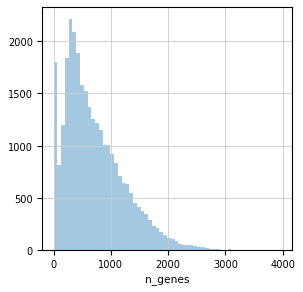

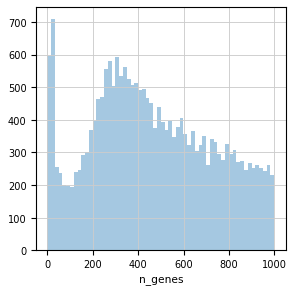

In [ ]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
pl.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
pl.show()

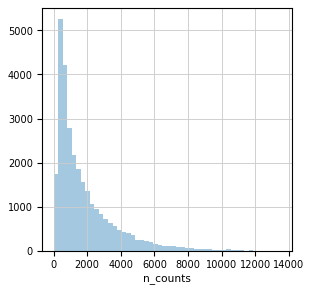

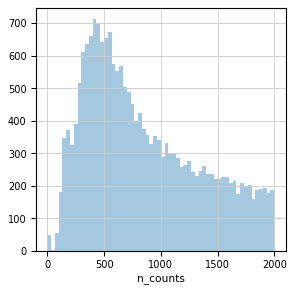

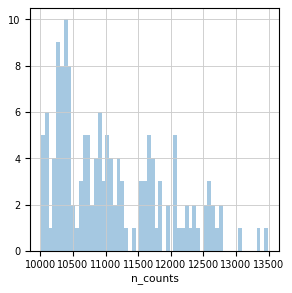

In [ ]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
pl.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<2000], kde=False, bins=60)
pl.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
pl.show()

In [ ]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 200)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 100000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 100)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 29648
Number of cells after min count filter: 28639
Number of cells after max count filter: 28639
Number of cells after MT filter: 25254


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 25205


In [ ]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=3)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 60671
Number of genes after cell filter: 20819


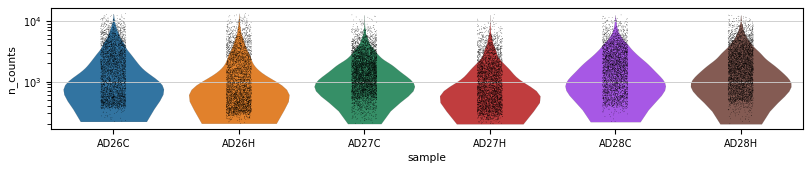

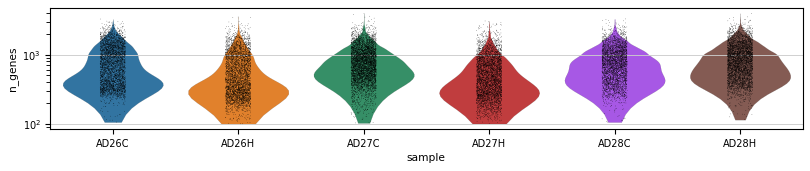

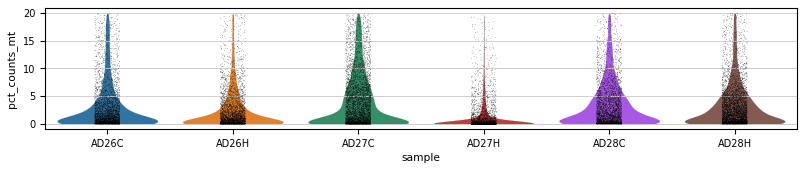

In [ ]:
pl.rcParams['figure.figsize']=(10,2)
pl.rcParams['lines.linewidth'] = 0.1
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=0.5, log=True, cut=0)
t2 = sc.pl.violin(adata, 'n_genes', groupby='sample', size=0.5, log=True, cut=0)
t3 = sc.pl.violin(adata, 'pct_counts_mt', groupby='sample',size=0.5)

In [ ]:
adata.var

,ambient_expression-AD26C,ambient_expression-AD26H,ambient_expression-AD27C,ambient_expression-AD27H,ambient_expression-AD28C,ambient_expression-AD28H,mito,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
gene_id,,,,,,,,,,,,,
STPG1,4.606567e-06,6.930071e-06,8.439428e-06,7.337662e-06,4.608042e-06,8.765895e-06,False,False,449,0.019413,98.454495,564.0,447
NIPAL3,1.040833e-05,1.197370e-05,3.218926e-05,4.605901e-05,8.899471e-06,2.388551e-05,False,False,1091,0.057311,96.244665,1665.0,1086
SPRTN,8.960921e-06,8.506283e-06,2.195462e-05,1.494750e-05,1.179851e-05,1.842626e-05,False,False,998,0.043508,96.564780,1264.0,996
CAMK1G,1.451562e-14,2.830176e-07,3.585230e-07,9.705222e-14,3.777601e-07,1.004807e-06,False,False,47,0.001928,99.838221,56.0,44
FAM76A,6.990523e-06,4.517006e-06,1.224668e-05,6.790319e-06,8.888199e-06,9.658342e-06,False,False,695,0.029292,97.607738,851.0,694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011751.1,1.844396e-07,3.076091e-14,1.646609e-06,9.455801e-07,2.091199e-07,4.874805e-07,False,False,50,0.002169,99.827895,63.0,49
AC024236.1,0.000000e+00,2.093515e-14,3.821111e-07,7.955556e-14,1.329524e-06,3.358120e-14,False,False,7,0.000241,99.975905,7.0,7
AC010889.2,0.000000e+00,0.000000e+00,8.458398e-07,6.816868e-14,2.416960e-14,1.131233e-13,False,False,6,0.000344,99.979347,10.0,6


# Normalization

## Scran

In [ ]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e4,exclude_highly_expressed=True,inplace=True)
sc.pp.log1p(adata_pp)

sc.pp.highly_variable_genes(adata_pp, flavor =flavor, n_top_genes = n_top_genes, subset = False)
sc.pp.pca(adata_pp, n_comps = n_comps, use_highly_variable = True)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=resolution)

In [ ]:
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -i input_groups
suppressPackageStartupMessages(library(scran))

In [ ]:
size_factors = ro.r(f'calculateSumFactors(data_mat, clusters = input_groups, min.mean = 0.1)')

In [ ]:
#Delete adata_pp
del adata_pp

In [ ]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [ ]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)
adata.X = sp.sparse.csr_matrix(adata.X)

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [ ]:
samplename='concatenated'
normalized=samplename+"_scran_normalized.h5ad"
adata.write(normalized)

In [ ]:
normalized=samplename+"_scran_normalized.h5ad"
adata=sc.read(normalized)
adata

In [ ]:
adata.obs

## sctransform using Seurat

In [ ]:
import scanpy as sc
from scipy.sparse import issparse


def pyScTransform(adata, output_file=None):
    """
    Function to call scTransform from Python
    """
    import rpy2.robjects as ro
    import anndata2ri

    ro.r('library(Seurat)')
    ro.r('library(scater)')
    anndata2ri.activate()

    sc.pp.filter_genes(adata, min_cells=5)
    
    if issparse(adata.X):
        if not adata.X.has_sorted_indices:
            adata.X.sort_indices()

    for key in adata.layers:
        if issparse(adata.layers[key]):
            if not adata.layers[key].has_sorted_indices:
                adata.layers[key].sort_indices()

    ro.globalenv['adata'] = adata

    ro.r('seurat_obj = as.Seurat(adata, counts="X", data = NULL)')

    ro.r('res <- SCTransform(object=seurat_obj, return.only.var.genes = FALSE,variable.features.n = 3000, do.correct.umi = FALSE,conserve.memory = FALSE,)')

    norm_x = ro.r('res@assays$SCT@scale.data').T
    HVG = ro.r('res@assays$SCT@var.features')

    adata.layers['normalized'] = norm_x
    adata.var["highly_variable"] = [g in HVG for g in adata.var_names]

    if output_file:
        adata.write(output_file)

In [ ]:
pyScTransform(adata)

In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [ ]:
adata.X=adata.layers["normalized"]
adata.layers["logcounts"] = adata.X

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [ ]:
normalized=samplename+"_SCT_normalized.h5ad"
adata.write(normalized)

In [ ]:
import scipy as sp

In [ ]:
adata.X=adata.layers['spliced']+adata.layers['unspliced']
#adata.X=adata.layers['spliced']
adata.X = sp.sparse.csr_matrix(adata.X)

## SCtransform with vst

In [ ]:
%cd /home/jupyter/bucket/AD_Final/Aligned/

In [ ]:
sctransform(
    adata= adata,
    regress_out= ('log_umi',),
    method='poisson',
    batch_key = None,
    n_top_genes = 3000,
    regress_out_nonreg = None,
    min_cells = 5,
    store_residuals = True,
    correct_counts= True,
    verbose= True,
    inplace= True,
    seed= 0,)

R[write to console]: Warning:
R[write to console]:  The 'show_progress' argument is deprecated as of v0.3. Use 'verbosity' instead. (in sctransform::vst)

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 18822 by 25205

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25205 cells



  |======================================================================| 100%


R[write to console]: Found 20 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 18822 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.992809 mins

R[write to console]: Calculating variance for residuals of type pearson for 18822 genes



  |======================================================================| 100%


R[write to console]: Computing corrected UMI count matrix



  |======================================================================| 100%


In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 3000


# Removal of Mitochondrial and Ribosomal Protein Genes

In [ ]:
#Identify mitochondrial genes
regex = re.compile('^(MT-).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
#Identify ribosomal protein genes using a pre-compiled list
with open('/home/jupyter/bucket/sctoolkit/RB_genes_human.txt') as f:
    ribo_genes = [s.strip("\n") for s in f.readlines()]
#Remove mitochondrial genes and ribosomal protein genes
adata_no_mito_RB = adata[:, [gene not in mito_genes + ribo_genes for gene in adata.var.index]].copy()
adata=adata_no_mito_RB

In [ ]:
# using corrected counts as X
adata.X=adata.layers["sct_corrected"]
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X

####################################
#using pearsons residuals as X
####################################

#adata.X=adata.layers["sct_residuals"]
#adata.layers["logcounts"] = adata.X

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [ ]:
normalized=samplename+"_vst_normalized.h5ad"
adata.write(normalized)


In [ ]:
normalized=samplename+"_vst_normalized.h5ad"
adata=sc.read(normalized)
adata

# Sellection of HVG

In [ ]:
#Expects logarithmized data.
sc.pp.highly_variable_genes(adata, flavor=flavor, n_top_genes=3000)
#sc.pp.highly_variable_genes(adata, flavor=flavor, n_top_genes=n_top_genes,batch_key='batch')
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

In [ ]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.highly_variable_genes(adata,highly_variable_genes=True,save='.pdf')

In [ ]:
# Extract cell cycle genes 
cell_cycle_genes = [x.strip() for x in open('/home/jupyter/cellcycle.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [ ]:
# compute gene scores for cell cycle genes which we will regress out
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# regress out effects of total counts per cell and scale genes to have unit variance
sc.pp.regress_out(adata, [ 'S_score', 'G2M_score'])

# PCA

In [ ]:
sc.pp.scale(adata,max_value=10)

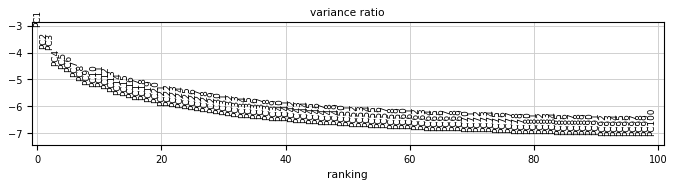

In [ ]:
sc.pp.pca(adata, n_comps = 100, use_highly_variable =True, svd_solver = "arpack")
sc.pl.pca_variance_ratio(adata, n_pcs = 100,log=True)

In [ ]:
sce.pp.bbknn(adata,batch_key='condition', n_pcs = 100,metric='angular')

In [ ]:
sce.pp.bbknn(adata,batch_key='sample',n_pcs=100)
#sce.pp.bbknn(adata,batch_key='sample',n_pcs=100,neighbors_within_batch =20)
#sce.pp.mnn_correct(adata,batch_key='run')

# Neighbors and clustering

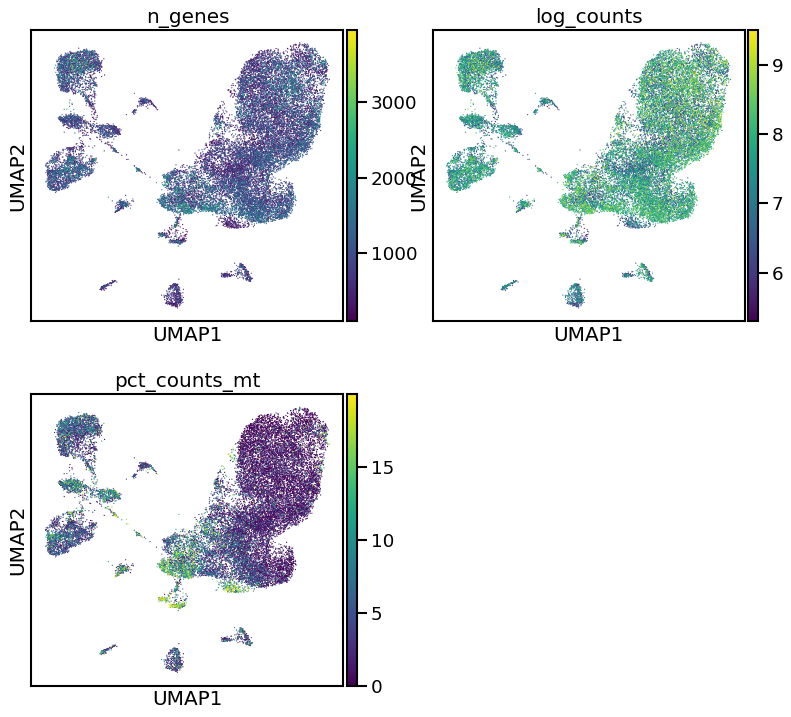

In [ ]:
#sc.pp.neighbors(adata, n_pcs=20,n_neighbors=20,random_state=random_state)
#bbknn.bbknn(adata,batch_key = "donor", neighbors_within_batch =15, n_pcs = 40)

sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#genes_to_plot = ['predicted_doublets','n_genes','log_counts','mt_frac']
genes_to_plot = ['n_genes','log_counts','pct_counts_mt']
sc.tl.umap(adata,random_state=random_state)
savefig=samplename+"_QC_doublets_vst_mito02.pdf"
sc.pl.umap(adata, color = genes_to_plot,ncols=2,save=savefig)

# Clustering

In [ ]:

sc.tl.leiden(adata,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')


In [ ]:
sc.tl.leiden(adata,random_state=random_state,resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata,random_state=random_state,resolution=1, key_added='leiden_r1')
sc.tl.leiden(adata,random_state=random_state, resolution=0.8, key_added='leiden_r0.8')
sc.tl.leiden(adata,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(adata,random_state=random_state, resolution=0.4, key_added='leiden_r0.4')
sc.tl.leiden(adata,random_state=random_state, resolution=0.3, key_added='leiden_r0.3')
sc.tl.leiden(adata,random_state=random_state, resolution=0.2, key_added='leiden_r0.2')

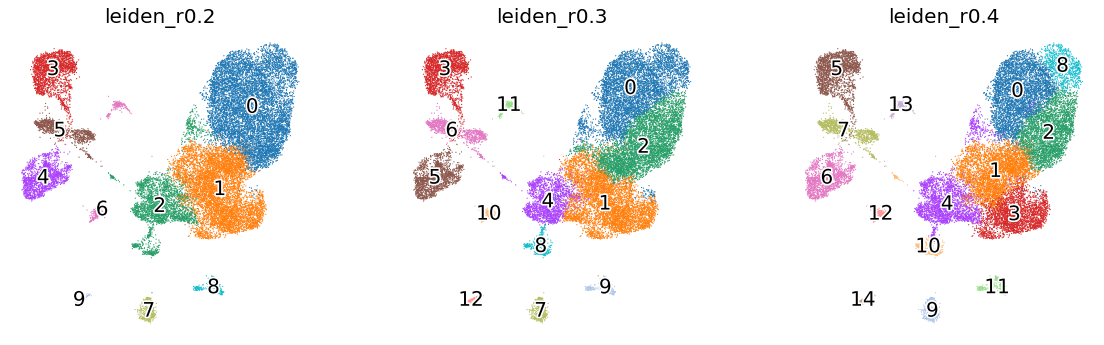

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_lores_vst.pdf"
sc.pl.umap(adata, color=['leiden_r0.2','leiden_r0.3','leiden_r0.4'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

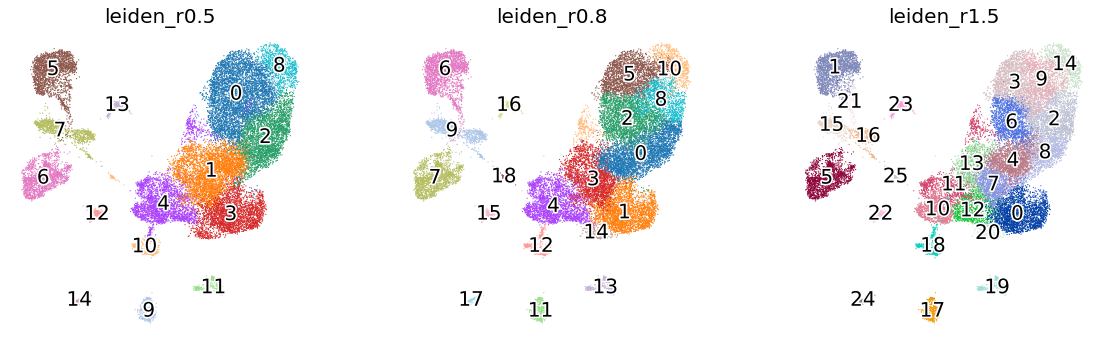

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['leiden_r0.5','leiden_r0.8','leiden_r1.5'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['annotated'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['condition'],legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
# Now assign clusters to cell types
cluster_assign = adata.obs['leiden_r0.8']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.01)
# Add to anndata object
adata.obs['scorect'] = celltype_assign
# Let's compare with the true assignment now! 
sc.pl.umap(adata, color=['annotated','scorect'], title=['True','Predicted'], cmap='Set2',legend_loc='on data')

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.8'].cat.add_categories(['DC1','DC2','pDC','NK cells','B cells','CD4 Memory','CD4 Naive',
                                                                      'CD8 Memory','GATA2 cells','Tregs','Plasma cells','MAIT','iNKT','CD8 Naive','CD8 TE','CD8 EM'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['7'])] = 'DC1'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['6',])] = 'DC2'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['12'])] = 'pDC'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['4'])] = 'NK cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1','10','11','14','5'])] = 'B cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['2'])] = 'CD4 Naive'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0'])] = 'CD8 Naive'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['15'])] = 'MAIT'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['9','3'])] = 'CD8 TE'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['8'])] = 'CD8 EM'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['16'])] = 'iNKT'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['17'])] = 'GATA2 cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['13'])] = 'Tregs'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['18'])] = 'Plasma cells'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
sc.tl.leiden(adata, resolution=0.08, restrict_to=('leiden_r0.8', ['11']),key_added='leiden_r08A')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_vst_bbknn.pdf"
sc.pl.umap(adata, color=['annotated','KLRF1'],legend_fontoutline=3, 
           hspace=0.5,wspace=0.5,legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sc.tl.leiden(adata, resolution=0.2, restrict_to=('leiden_r0.8', ['10']),key_added='leiden_r08A')
sc.tl.leiden(adata, resolution=0.2, restrict_to=('leiden_r08A', ['7']),key_added='leiden_r08B')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['leiden_r08B'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['sample',	'condition',	'donnor'],legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
for condition in ['CTR', 'LPS', 'VitD3','LPS_VitD3']:
    sc.pl.umap(adata, color='condition', groups=[condition])

In [ ]:
cluster=samplename+"_leiden_cl_vst.h5ad"
adata.write(cluster)

In [ ]:
cluster=samplename+"_leiden_cl_vst.h5ad"
adata=sc.read(cluster)

In [ ]:

Tcells.write('Tcells_All.h5ad')

In [ ]:
TcellsDC=adata[adata.obs['leiden_r1'].isin(['5','11']),:].copy()
TcellsDC



In [ ]:

TcellsDC.write('TcellsDC_All.h5ad')

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_annotated_vst.pdf"
sc.pl.umap(adata, color=['annotated'],legend_fontoutline=3,legend_loc='on data', legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_annotated_vst.pdf"
sc.pl.umap(adata, color=['annotated'],legend_fontoutline=3,legend_loc='on data', legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
adata=sc.datasets.pbmc3k_processed()
adata

# Automatic Annotation

In [ ]:
# Import modules
import os
import sys
import pandas as pd
import scanpy as sc

sys.path.append('/home/jupyter/scoreCT/src')
import scorect_api as ct


# Load reference table - scoreCT api provides a wrapper for gmt, tsv and csv formats.
#ref_marker = ct.read_markers_from_file('/home/jupyter/scoreCT/data/ref_marker.gmt')
#ref_marker = ct.read_markers_from_file('/home/jupyter/scoreCT/data/c8.all.v7.4.symbols.gmt')
#ref_marker = ct.read_markers_from_file('/home/jupyter/scoreCT/data/ref_marker.csv')
ref_marker = ct.read_markers_from_file('/home/jupyter/scoreCT/data/covid200.gmt')

In [ ]:
# added `n_genes` to store information in all genes. This is needed if we want to plot log fold changes or pvalues
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.8', n_genes=100, method='wilcoxon',corr_method="bonferroni")

In [ ]:

# Wrangle results from existing sc.tl.rank_genes_groups() results
# Let's have a look for cluster 0
marker_df = ct.wrangle_ranks_from_anndata(adata)
print(marker_df.head())

In [ ]:

# Score cell types for each cluster 
# Let's set parameters first - K represents the number of genes included in the ranking
# m represents the number of bins used to divide the top K genes.
K = 100
m = 5
# Get the background genes - here, all the genes used to run the differential gene expression test
background = adata.raw.var.index.tolist()
# Now run the function
ct_pval, ct_score = ct.celltype_scores(nb_bins=m,
                                        ranked_genes=marker_df,
                                        K_top = K,
                                        marker_ref=ref_marker,
                                        background_genes=background)

In [ ]:
adata['louvain']

In [ ]:

# Let's have a look at the pvalue for cluster 0
ct.plot_pvalue(ct_pval, clusters=['0','2'], n_types=5)

In [ ]:
# Now assign clusters to cell types
cluster_assign = adata.obs['leiden_r0.8']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.01)
# Add to anndata object
adata.obs['scorect'] = celltype_assign
# Let's compare with the true assignment now! 
sc.pl.umap(adata, color=['leiden_r0.8','scorect'], title=['True','Predicted'], cmap='Set2')


In [ ]:
##### scanpy_pbmc_3k.csv was genearted by following command from anndata object:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv("/home/jupyter/scanpy_allsamples1.csv")


In [ ]:
  
!python3 SCSA.py -d whole.db -i /home/jupyter/scanpy_allsamples.csv -s scanpy -E -f1.5 -p 0.01 -o result -m txt 

In [ ]:
# copy and paste the raw output for umap
umap_annotation_output=[['0', 'Good', 'T cell', 7.191632096535123, 2.4522001013285704],
['1', '?', 'T cell|Natural killer cell', '5.935655836575124|3.808139808967671', 1.558675924291811],
['10', '?', 'Plasmacytoid dendritic cell|Epithelial cell', '7.423531729231203|4.19022870956907', 1.7716292459832466],
['11', '?', 'Macrophage|Monocyte', '6.371700618796468|5.188979375131168', 1.2279294555175224],
['12', '?', 'B cell|Myeloid dendritic cell', '5.107022519209462|3.937919463742867', 1.2968834345726816],
['13', '?', 'Macrophage|Microglial cell', '5.884744749738859|3.9500134463344416', 1.4898037259087868],
['14', '?', 'T cell|Natural killer cell', '5.538083542179843|4.499244251087628', 1.230891952763198],
['15', '?', 'Natural killer cell|Natural killer T (NKT) cell', '6.657753255725463|4.275001452555014', 1.5573686534647522],
['16', '?', 'Microglial cell|Hematopoietic stem cell', '4.206890431150358|4.0730014935027965', 1.0328723026154396],
['17', 'Good', 'B cell', 7.869261739122865, 3.439511316080445],
['2', 'Good', 'B cell', 8.38204028006332, 6.769519253694071],
['3', '?', 'T cell|Natural killer cell', '6.094299646278045|4.10325564998463', 1.4852351805817587],
['4', 'Good', 'Natural killer T (NKT) cell', 6.419665614525071, 6.82817100222041],
['5', 'Good', 'Natural killer cell', 8.143588199479852, 2.8724755450126174],
['6', 'Good', 'T cell', 6.987229806475998, 2.8943539869344854],
['7', '?', 'Regulatory T (Treg) cell|Myeloid dendritic cell', '4.44209399558609|3.6772352975896427', 1.207998302011785],
['8', 'Good', 'B cell', 8.821669472196776, 8.091433685460105],
['9', 'Good', 'B cell', 9.076913164698928, 5.343191728161601]]


# extract annotations
umap_cluster_names = [None for _ in range(len(umap_annotation_output))]
for annotation in umap_annotation_output:
    index = int(annotation[0])
    name = annotation[2]
    umap_cluster_names[index] = name

In [ ]:
# Make cluster by cluster plots
def plot_by_cluster(adata, clust_key, size=60, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]

    sc.pl.umap(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, legend_loc=legend_loc, **kwargs)


In [ ]:
# Map annotations to abbreviated names
def annotation_abbr(annotations):
    tmp = []
    for ann in annotations:
        ann = ann.replace('Natural killer T (NKT) cell','NKT')
        ann = ann.replace('Hematopoietic stem cell','HSC')
        ann = ann.replace('Mesenchymal stem cell','MSC')
        ann = ann.replace('Natural killer cell','NK')
        ann = ann.replace('Embryonic stem cell','ESC')
        ann = ann.replace('Regulatory T (Treg) cell', 'Treg')
        ann = ann.replace(' (Th1)','')
        ann = ann.replace('T helper', 'Th')
        ann = ann.replace(' cell','')
        ann = ann.replace('-','UND')
        tmp.append(ann)
    return tmp

In [ ]:
def names_make_unique(annotations):
    ann_dic = {}
    # construct dictionary for all names, cluster indices will be stored for each name
    for i,ann in enumerate(annotations):
        if ann_dic.get(ann)==None:
            ann_dic[ann] = [i]
        else:
            ann_dic[ann].append(i)
    #  
    for ann in ann_dic:
        num = len(ann_dic[ann])
        if num > 1:
            for indx in ann_dic[ann]:
                annotations[indx] = '('+ann+')'+'_'+ str(num)
                num -= 1
    return annotations


In [ ]:
umap_cluster_names = annotation_abbr(umap_cluster_names)
umap_cluster_names = names_make_unique(umap_cluster_names)
# View cluster annotations and get the number of labels that needs extra attention
for i,name in enumerate(umap_cluster_names):
    print((i,name))

adata.rename_categories('leiden_r0.8', umap_cluster_names)
fig, ax = pl.subplots(figsize=(12,12))
sc.pl.umap(adata, color='leiden_r0.8',legend_loc='on data',frameon=False,ax=ax)

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata, color=['leiden_r0.8','leiden_r08B'],legend_loc='on data',frameon=False)

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.5'].cat.add_categories(['Plasmacytoid DC','DC1','DC2','DC3','DC4','(B)_1','(B)_2','(B)_3','(B)_4','(B)_5','NK'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['6'])] = 'TCells'


adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
import scplot as scp

In [ ]:
import holoviews as hv

def _render(self, **kw):
  hv.extension('bokeh')
  return hv.Store.render(self)
hv.core.Dimensioned._repr_mimebundle_ = _render

In [ ]:
# Sort binned_n_counts by mean fraction across all louvain clusters
cmap={'0':'#e41a1c','8': 'LightGrey', '9':'black'}
scp.composition_plot(adata,  'annotated','treatmentcondition', height=400, condition_sort_by='mean')

In [ ]:
# Sort binned_n_counts by mean fraction across all louvain clusters
cmap={'0':'#e41a1c','8': 'LightGrey', '9':'black'}
scp.composition_plot(adata,  'treatmentcondition','annotated',  height=400, condition_sort_by='mean')

In [ ]:
TcellsDC=adata[adata.obs['leiden_r1'].isin(['1']),:].copy()
TcellsDC

In [ ]:
Tcells=adata[adata.obs['leiden_r1'].isin(['1']),:].copy()
Tcells

In [ ]:
Tcells.write('Tcells_All.h5ad')

In [ ]:
TcellsDC.write('TcellsDC_All.h5ad')

In [ ]:
Tcells=adata[adata.obs['leiden_r0.5'].isin(['6']),:].copy()
Tcells

In [ ]:
Tcells.write('Tcells_All.h5ad')

In [ ]:
DC=adata[adata.obs['leiden_r0.5'].isin(['8']),:].copy()
DC

In [ ]:
DC.write('DC_All.h5ad')

In [ ]:
regex = re.compile('^(CD207).*', re.IGNORECASE)
genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
genes

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_Umap_Annotated_vst_MTs.pdf"
sc.pl.umap(adata, color=['MT2A',
 'MT1A',
 'MT1E',
 'MT1H',
 'MT1B',
 'MT1F',
 'MT1G',
 'MT1M',
 'MT1X',],legend_fontoutline=3,legend_loc='on data',color_map=mymap,vmax=2,legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
for batch in ['AD13_C', 'AD13_H', 'AD19_C','AD19_H']:
    sc.pl.umap(adata, color='sample', groups=[batch])

In [ ]:
sc.tl.embedding_density(adata, groupby='sample')

In [ ]:
sc.pl.embedding_density(adata, groupby='sample')

In [ ]:
adata= adata[~adata.obs['leiden_r0.4'].isin(['3']),:].copy()
adata

In [ ]:
cluster=samplename+"_leiden_cl_vst.h5ad"
adata.write(cluster)


In [ ]:
cluster=samplename+"_leiden_cl_vst.h5ad"
adata=sc.read(cluster)
adata

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_clustering_vst_1.pdf"
sc.pl.umap(adata, color=['annotated'],legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
#PBMC marker genes
marker_genes = ['IDO1','IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B','CD4', 'LYZ', 'CD14','LGALS3', 'S100A8', 'GNLY', 'NKG7','NCR1', 'KLRB1','FCGR3A', 'MS4A7', 'FCER1A', 'CST3','HLA-DRA', 'PPBP']

In [ ]:
#Skin marker genes
marker_genes=['GATA3', 'KRTDAP', 'KRT1', 'DMKN', 'ITGA6', 'KRT14', 'KRT5', 'S100A2', 'CRYAB', 'TYRP1', 
'PTGDS', 'DCT', 'PMEL', 'FGL2', 'PMP22', 'LUM', 'APOD', 'NT5E', 'TNFAIP6', 'DCN', 
'CFD', 'RGS5', 'MGP', 'TFPI', 'CCL21', 'TFF3', 'FABP4', 'CD34', 'PECAM1', 'TM4SF1',
'SPARCL1', 'SERPINE1', 'KIT', 'TPSB2', 'TPSAB1', 'CTSG', 'GNLY', 'XCL2', 'XCL1', 
'KLRB1', 'IL7R', 'CXCR4', 'CD3E','CD4', 'CD8A', 'CD8B', 'CD7', 'CD3D', 'TRAC', 
'CD5', 'CD4', 'FOXP3','CTLA4', 'TIGIT', 'CD247', 'IGKC', 'IGLC2', 'IGHA1', 'GZMB', 
'JCHAIN', 'PLEK', 'ACOT7', 'HLA-DQB2', 'HLA-DQA1', 'CCR7', 'HLA-DRA', 'CXCL8', 'RNASE1', 
'CCL3','CD207','CD79A','KRT16','KRT17','KRT6A']

In [ ]:
print(len(marker_genes))
filter=np.in1d(marker_genes, adata.var_names)
marker_genes = list(np.array(marker_genes)[filter])
print(len(marker_genes))
marker_genes.append("leiden_r0.5")
marker_genes.append("sample")

74
70


In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_markers_vst_1.pdf"
sc.pl.umap(adata=adata, color=marker_genes,color_map=mymap,vmin=0.0, vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=True, save=savefig)

In [ ]:
adata.write('Cellbender_DS_vst_leiden.h5ad')

In [ ]:
adata=sc.read('Cellbender_CDS_vst_leiden.h5ad')

In [ ]:
adatab=sc.read('/home/jupyter/bucket/AD_Dropseq/Dropseq/Velo/All_leiden_cl_vst.h5ad')
adatab

AnnData object with n_obs × n_vars = 34010 × 26668
    obs: 'sample', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_doublet', 'batch', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2'
    var: 'gene_name', 'mito', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells_by_counts-3', 'mean_co

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig="notcleaned_markers_vst_1.pdf"
sc.pl.umap(adata=adatab, color=marker_genes,color_map=mymap,vmin=0.0, vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=True, save=savefig)

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_markers_vst_reds.pdf"
sc.pl.umap(adata=adata, color=marker_genes,color_map='Reds',vmin='p10', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=True, save=savefig)

In [ ]:
regex = re.compile('^(MT).*', re.IGNORECASE)
genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
genes

In [ ]:
genes=['KRT17', 'KRT16', 'KRT6A','MT2A']

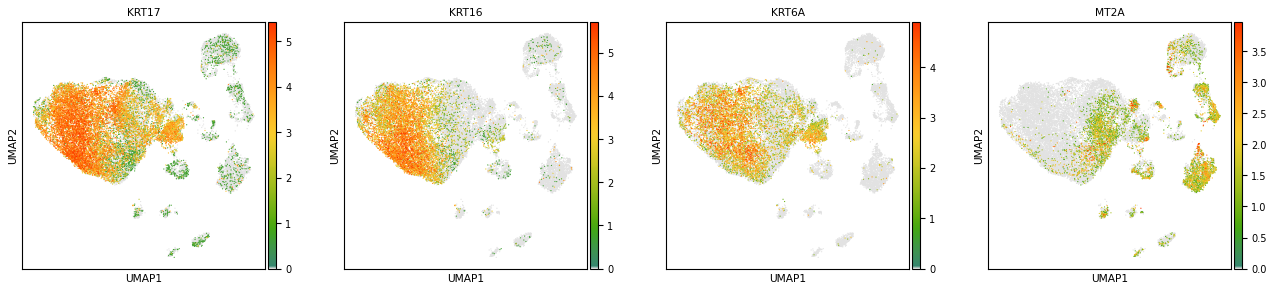

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_markers_vst_reds.pdf"
sc.pl.umap(adata=adata, color=genes,color_map=mymap,vmin='p10', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=True, save=savefig)

In [ ]:
sc.pl.stacked_violin(adata,genes,groupby='sample',dendogram=False,swap_axes=False, cmap=cc.cm.rainbow_bgyr_35_85_c72,figsize=(4,12),save='violin_DEG.pdf')

In [ ]:
order=[	'CTR', 'VitD3', 'LPS','LPS_VitD3']

In [ ]:
adata= adata[adata.obs['leiden_r0.5'].isin(['5']),:].copy()
adata

In [ ]:
adata.write('Tcells_All.h5ad')

# Marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_r0.8', method='logreg',n_genes=100)
markers=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:
savemarkers1=samplename+"_logreg_vst_r0.5.csv"
markers.to_csv(savemarkers1)

In [ ]:
# added `n_genes` to store information in all genes. This is needed if we want to plot log fold changes or pvalues
sc.tl.rank_genes_groups(adata, groupby='leiden_r1', n_genes=adata.shape[1], method='wilcoxon',corr_method="bonferroni")

In [ ]:
markers=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(40)
markers

In [ ]:
savemarkers1=samplename+"_wilcoxon_vst_r1.csv"
markers.to_csv(savemarkers1)

In [ ]:
savefig=samplename+"_markers_dotplot_vst_1.pdf"
#sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=2, vmax=7, vmin=-7, cmap='bwr',save=savefig)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, values_to_plot='logfoldchanges',vmax=2,vmin=-2, cmap='bwr',save=savefig)

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot='logfoldchanges', vmax=1, vmin=-1, cmap='bwr', groups=['2', '4'])

In [ ]:
savefig=samplename+"_markers_vplot_vst_1.pdf"
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=4, cmap='Reds',save=savefig)

In [ ]:
adata.obs

## Focusing on particular groups

In [ ]:
adata.obs['clusterdonor'] = adata.obs['condition'].astype(str)+adata.obs['leiden_r0.8'].astype(str)
adata.obs['clusterdonor']=adata.obs['clusterdonor'].astype('category')

In [ ]:
adata.obs['clusterdonor']

In [ ]:
# added `n_genes` to store information in all genes. This is needed if we want to plot log fold changes or pvalues
sc.tl.rank_genes_groups(adata, groupby='clusterdonor', n_genes=adata.shape[1], method='wilcoxon',corr_method="bonferroni",groups=['CTRTregs','VitD3Tregs'])
markers=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:
markers=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:
# added `n_genes` to store information in all genes. This is needed if we want to plot log fold changes or pvalues
sc.tl.rank_genes_groups(adata, groupby='clusterdonor', n_genes=adata.shape[1], method='wilcoxon',corr_method="bonferroni",groups=['CTRPlasmacytoid dendritic|Epithelial','VitD3Plasmacytoid dendritic|Epithelial','LPSPlasmacytoid dendritic|Epithelial','LPS_VitD3Plasmacytoid dendritic|Epithelial'])
markers=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, values_to_plot='logfoldchanges',
                                min_logfoldchange=1, vmax=2, vmin=-2, cmap=mymap, groups=['CTRPlasmacytoid dendritic|Epithelial','VitD3Plasmacytoid dendritic|Epithelial','LPSPlasmacytoid dendritic|Epithelial','LPS_VitD3Plasmacytoid dendritic|Epithelial'])

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='clusterdonor', method='wilcoxon',groups= ['VitD3Tregs'], reference='CTRTregs', rankby_abs=False)

In [ ]:
markers=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:

markers=pd.DataFrame(adata.uns['rank_genes_groups']['names'],adata.uns['rank_genes_groups']['scores']).head(100)
markers

In [ ]:
markers.to_csv('Plasmacitoid_Vitd3_vs_CTR.csv')

In [ ]:
pl.rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, size=10, n_genes=40)

# Gene ontology 

In [ ]:
markers1=markers.to_dict('list')

In [ ]:
def plot_enrichment(
    genes,
    num_pathways=20,
    title='',
    ordered=True,
    cutoff=0.05,
    sources=('GO:BP', 'HPA','REAC','KEGG'),
    organism='hsapiens',
    return_df=False,
):
    en_df = sc.queries.enrich(genes, org=organism, gprofiler_kwargs=dict(no_evidences=False, ordered=ordered, all_results=True, user_threshold=cutoff, sources=sources))
    en_df['name'] = en_df['name'].str.capitalize()
    en_df['intersections'] = ['(' + ','.join(x[:5]) + ')' for x in en_df.intersections]
    en_df['name'] = en_df['name'].astype(str) + ' ' + en_df['intersections'].astype(str)
    en_df = en_df.drop_duplicates('name')[:num_pathways]
    en_df['neglog10_pval'] = -np.log10(en_df['p_value'])
    en_df['name'] = pd.Categorical(en_df['name'], categories=en_df['name'], ordered=True)

    figsize = (7,len(en_df)/4)
    text_start = (en_df.neglog10_pval.max()*0.01)

    g = (
        ggplot(en_df, aes(x='name', y='neglog10_pval')) +
        geom_bar(aes(fill='significant'), stat='identity', color='#0f0f0f', size=0.1) +
        geom_hline(yintercept=-np.log10(cutoff), size=0.05, color='black') +
        geom_text(aes(x='name', y=text_start, label='name'), size=8, ha='left') +coord_flip() +
        scale_x_discrete(limits=list(reversed(en_df.name.cat.categories))) +
        scale_fill_manual({True:'#D3D3D3', False:'#efefef'}) +
        theme_classic() +
        theme(
            figure_size=figsize, panel_spacing_x=1.,
            axis_text_y = element_blank(),
            legend_position = 'none',
        ) +
        labs(y='Gene Set Enrichment (-log10(adj. P value))', x='Pathways', title=title)
    )

    if not return_df:
        return g
    else:
        return g, en_df


In [ ]:
for clust in markers1.keys(): 
    fig=plot_enrichment(markers1[clust],
    num_pathways=20,
    title='',
    ordered=True,
    cutoff=0.05,
    organism='hsapiens',
    return_df=False)
    title="cluster" + clust
    print(title)
    print(fig)

# Plotting marker genes

In [ ]:
markers={'Migrated': ['CCL22','LAMP3','BIRC3','NUB1','CCR7','FSCN1','TBC1D4','IRF4','IL7R','CD83','IER5','GPX4','CCL17','RGS1','CSF2RA','DAPP1','G0S2','ALDH2','BASP1','MARCKSL1'],
         'SS':['HLA-DQB2','FCGBP','CD207','S100B','RGS1','TBC1D4','LMNA','SLC18A2','CD1A','B2M','RGS2','PLEK2','HLA-DRB1','LCP1','SLC38A1','KRT10','HLA-DQA2','CLDN1','CD74','HLA-DQB1']}

In [ ]:
markers={'Migrated': ['TMSB10','MYL6','B2M','FSCN1','TUBA1A','COTL1','HLA-B','GSTP1','ACTG1','DUSP5','PFN1','NUB1','ANXA6','TYMP','RAMP1','CCL22','CFL1','LGALS1','GSN','NCCRP1','CD74','RPS27L','LAMP3','MARCKSL1','DPYSL2','GPX4','PEA15','ACTN4','RASSF2','LY75','HMOX1','CXCL16','LYZ','GRINA','S100A9','GNAI2','IDO1','ATOX1','SYNGR2','ABCB10','AOC1','CTSZ','ALDH2','ARRB2','CHD3','RAB9A','FDFT1','NECAP2','TUBA1B','BIRC3'],
         'SS':['HSPA5','C15orf48','HLA-DRB5','HLA-DQB2','EEF1A1','HLA-DQB1','HLA-DQA1','CD207','MMP9','IL8','MT-CO1','RPL10','NCL','G0S2','MTRNR2L1','RPS2','RPL3','PTMA','GPR183','YBX1','NPM1','MT-ND5','HSPD1','DDX21','NAMPT','TMSB4X','RPS7','RPS18','RPL9','NFKBIA','LMNA','RPL6','MT-ATP6','RPL4','ZFP36','TPT1','RPL23A','RPS16','RPL13A','RPS3A','RPS25','GLIPR1','HSP90AB1','MT-ND2','CST3','RPLP0','RPL14','RPS15A','RPS23','AGPAT9']}

In [ ]:
markers={'Th1':['IL2','IL27','IL27RA','IL36G','STAT1','STAT4','IFNG','CXCL10','CXCL9'],
         'Th2':['IL4','IL5','IL13','IL31','IL33','CCL13','CCL17','CCL18','CCL22'],
         'Th17':['IL12B','IL17A','IL17C','IL17F','IL22','IL23A','STAT3','CXCL1','CXCL2','S100A7A','S100A7','S100A8','S100A9'],
         'NK':['GZMB','PRF1','KLRD1','FCGR3A','CD226','CRTAM','PRDM1'],
         'Skin_barrier':['ADAM15','ALDH3A1','DEGS2','ELOVL1','FABP3','FABP4','FABP9','GJB5','GJB7','ITGA1','KLK5','KLK9','KLK11','KLK14','KRT7','KRT10','LCE2A','SDC1','KRT1','KRT16','FLG','FLG2','LOR','ELOVL3','ELOVL6','SERPINB4','LCE1B','LCE1C','LCE3A','LCE3C','LCE3D','LCE3E'], 
}

In [ ]:
# from HCA 
markers={'DC1_gene': ['MALAT1','HLA-DRA','HLA-DQB1','HLA-DPB1','GPR183','CD74','HLA-DQA1','PLEK','HLA-DPA1','HLA-DRB1','HLA-DRB5','NAP1L1','NEAT1','HLA-DMA','GNA15','SRGN','BID','CXCR4','LSP1','RPS11','SYNGR2','SEC61B','RPS29','RGS1','CD83','CSF2RA','SAT1','CYTIP','IL4I1','RPL27A'],
 'DC2_gene': ['HSPA1A','HSPA1B','HLA-DRA','LST1','HLA-DQB1','HLA-DPB1','LYZ','HLA-DPA1','AIF1','CST3','HLA-DRB1','HLA-DQA1','HSPA6','CD74','IL1R2','FCER1A','HLA-DRB5','LGALS2','SGK1','RGS1','CLEC10A','HLA-DMA','CXCL8','CD83','FCER1G','DNAJB1','GPR183','PLAUR','RGS2','HSP90AA1'],
 'Fb1_gene': ['MMP2','TNFAIP6','PTGES','THBS2','C1S','PDPN','COL6A2','DCN','NNMT','C1R','CRISPLD2','MMP14','COL6A1','SLC39A14','IGFBP4','SOD2','PLPP3','SELENOM','CTSK','APOD','AEBP1','VCAN','MT2A','GYPC','SERPING1','CTSL','NAMPT','CFH','SERPINE2','CFD'],
 'Fb2_gene': ['DCN','COL6A2','COL6A1','CCDC80','COL1A1','CFD','COL1A2','CTSK','MEG3','APOD','NNMT','VIM','C1S','MFAP4','DPT','TNFAIP6','MMP2','CFH','SERPING1','SFRP2','COL3A1','SERPINF1','LUM','GEM','VCAN','C1R','PMP22','MT1M','ADIRF','PLPP3'],
 'Fb3_gene': ['TNFAIP6','PTGES','MEDAG','MMP2','C1S','NNMT','SELENOM','COL6A2','CRISPLD2','SERPINE2','PDPN','SLC39A14','CTSL','CFD','C1R','CFH','PLPP3','MT2A','GYPC','SOD2','IGFBP7','IL6','DCN','C3','THBS2','ABI3BP','COL6A1','FGF7','AEBP1','BNIP3L'],
 'ILC1_3_gene': ['XCL1','KLRB1','AREG','CTSW','XCL2','CD96','FCER1G','LINC01871','TNFRSF18','FXYD5','RAC2','PTPRC','TSC22D3','CD53','PLAC8','SYTL3','JAML','SRGN','GNLY','CD7','IKZF1','SARAF','STK17B','CD69','CYTIP','ACAP1','PRF1','AHI1','IL7R','PRKX'],
 'ILC1_NK_gene': ['CD7','KLRB1','XCL1','KLRC1','XCL2','KLRD1','CD247','NKG7','PIK3R1','FCER1G','PTPRC','SRGN','IFITM2','CTSW','CXCR4','AREG','PRF1','FYN','ALOX5AP','LEPROTL1','CD96','SYTL3','SARAF','RAC2','GZMA','GNLY','CEMIP2','ARHGDIB','CD69','IFITM1'],
 'ILC2_gene': ['KLRB1','IL7R','JAML','PTPRC','CXCR4','SARAF','TSC22D3','SPOCK2','LTB','TRBC1','LEPROTL1','ARHGDIB','CD52','CD69','PBXIP1','FXYD5','TXNIP','TRAC','IL32','EVL','LAPTM5','SRGN','PPP2R5C','CD48','LMO4','S100A4','RORA','STK17B','CD37','TRBC2'],
 'Inf_mac_gene': ['CXCL8','CD83','SERPINB9','REL','HLA-DRA','C15orf48','HLA-DPB1','CCL22','HLA-DQA1','MYO1G','CSF2RA','GPR183','FAM49A','HLA-DRB1','CCR7','MIR155HG','CD74','MALAT1','KYNU','MAP4K4','SAT1','RGS1','HLA-DPA1','SAMSN1','FNBP1','GPR157','MT-ND4','CST7','ST8SIA4','BCAT1'],
 'LC_1_gene': ['HLA-DQB2','FCER1A','LST1','CD207','CD1A','HLA-DQB1','RGS1','FCGBP','ACOT7','HLA-DPB1','HLA-DRA','S100A4','S100B','AIF1','DBI','CD74','HLA-DPA1','HLA-DRB1','HLA-DQA1','HPGDS','HSPA1B','HSPA1A','HLA-DRB5','CPVL','CRIP1','CD83','HLA-DQA2','TBC1D4','CD52','TYROBP'],
 'LC_2_gene': ['RGS1','ACOT7','HLA-DQB2','SGK1','RGS2','HSPA1A','HLA-DRB1','MTSS1','HLA-DQA1','HLA-DRA','HLA-DPB1','HSPA1B','HLA-DQB1','CORO1C','HLA-DRB5','CD207','CD83','CD74','LST1','HLA-DPA1','CCL22','GPR183','HLA-DQA2','GNA13','FCGBP','SPI1','C15orf48','LCP1','S100A4','FAM49A'],
 'LC_3_gene': ['HLA-DQB2','HLA-DRB1','HLA-DRB5','HLA-DQA1','RGS1','HLA-DRA','ACOT7','HLA-DQB1','C15orf48','HLA-DPA1','HLA-DPB1','CCL22','TXN','CST7','CD74','GPR183','CD83','RALA','MMP9','MTSS1','TMSB4X','GPAT3','FAM49A','CMTM6','MAP4K4','SEC61B','TYROBP','SQLE','DAPP1','TALDO1'],
 'LC_4_gene': ['CCL22','CST7','HLA-DQB2','HLA-DRB5','IDO1','HLA-DQA1','HLA-DRB1','GPR183','HLA-DPA1','HLA-DPB1','TXN','HLA-DQB1','HLA-DRA','CD74','SERPINB9','ACOT7','CD83','SEC61B','CCR7','GPR157','ITM2C','LAD1','C15orf48','TBC1D4','LAMP3','FAM49A','RAMP1','MTSS1','MMP9','KYNU'],
 'LE1_gene': ['CCL21','TFF3','TFPI','ADIRF','CLDN5','CAVIN2','MMRN1','GNG11','GADD45B','ECSCR','TM4SF1','IGFBP7','EFEMP1','PPFIBP1','SNCG','VIM','HSPB1','TIMP3','LYVE1','RAMP2','CRIP2','ID3','NNMT','CCL2','ARL4A','SOX4','FABP5','FABP4','PLPP1','HSPA1A'],
 'LE2_gene': ['MMRN1','TFPI','AKR1C1','CCL21','AKR1C3','STMN1','CLDN5','ACTN1','CD59','NNMT','PDPN','CNKSR3','SOD2','PPFIBP1','ANGPT2','CNN3','HEBP1','APP','PDLIM4','DEPP1','SDCBP','IGFBP7','IFITM3','NUPR1','SNCA','SLC39A14','TFF3','TM4SF1','STOM','CD200'],
 'Mast_cell_gene': ['TPSB2','TPSAB1','HPGDS','HPGD','CTSG','CPA3','IL1RL1','LAT','HDC','FCER1G','VWA5A','GATA2','S100A4','KIT','RAC2','SH3BGRL3','GLUL','RGS13','LXN','RGS2','MS4A2','LAPTM5','CALB2','RHEX','CMA1','LGALS3','S100A6','SMYD3','RARRES1','GCSAML'],
 'Macro_1_gene': ['RNASE1','FTL','CTSB','FCER1G','C1QC','CTSL','TYROBP','C1QB','CD68','CD163','FTH1','MS4A7','TGFBI','SRGN','PLD3','S100A9','C1QA','TYMP','MMP9','C15orf48','LILRB4','GLUL','EMP3','ABCA1','SPI1','MAFB','CTSZ','HLA-DRA','CXCL8','PSAP'],
 'Macro_2_gene': ['HSPA1A','HSPH1','CXCL8','HLA-DRA','HSPA1B','FCGR2A','EMP3','HSPB1','HSPA6','TYROBP','DNAJB1','CD83','HSP90AA1','GPR183','CCL3','CCL4','HLA-DRB1','CTSZ','CXCL2','PLEK','RNASE1','GADD45B','MS4A6A','AIF1','FCER1G','FTL','FGL2','CD68','CXCL3','C5AR1'],
 'Melanocyte_gene': ['MLANA','DCT','PMEL','TYRP1','CDC42EP3','MITF','QPCT','VIM','PLP1','CAPN3','GPM6B','KIT','APOE','TYR','CYB561A3','PCSK2','HMG20B','PMP22','TRPM1','VAT1','IGFBP7','RAB32','STMN1','EMP3','CRABP1','ST3GAL4','INPP4B','BCAN','GPR143','PEBP1'],
 'MigDC_gene': ['BIRC3','HLA-DPB1','CCR7','CSF2RA','CD74','CD83','LAMP3','IDO1','HLA-DRA','GPR157','HLA-DPA1','CST7','ID2','DAPP1','HLA-DRB1','TXN','HLA-DQA1','LSP1','FSCN1','HLA-DQB1','MARCKSL1','DUSP5','MYO1G','RGS1','CCL22','TBC1D4','SYNGR2','ANXA6','TMSB4X','REL'],
 'Mono_mac_gene': ['FCER1G','CXCL8','CXCL3','TYROBP','CXCL2','MMP9','LYZ','EREG','CTSB','SRGN','C15orf48','FTL','FTH1','IL1B','MS4A7','CD14','PLAUR','PILRA','TIMP1','PID1','CD68','PLA2G7','CXCL5','THBS1','ANPEP','TNFRSF1B','CTSL','RNASE1','HLA-DRA','CXCL16'],
 'NK_gene': ['NKG7','GNLY','GZMB','KLRB1','CD7','CD247','KLRD1','PRF1','GZMA','CMC1','CCL5','CCL4','PYHIN1','PTPRC','FCER1G','CST7','RAC2','ITGB2','CTSW','CD48','FCGR3A','SH2D1B','FGFBP2','HCST','PLAC8','WIPF1','GZMH','SH2D2A','APMAP','CHST12'],
 'Pericyte_1_gene': ['CALD1','TFPI','RGS5','PDGFRB','PLPP3','EDNRB','SELENOM','PLIN2','IFITM3','ZFP36L1','CNN3','KCNE4','CPE','EDNRA','MGP','BNIP3L','SMIM3','COL4A1','COL6A2','IGFBP7','NDUFA4L2','PRKAR1A','HIPK2','COL4A2','PTGES','ZNF503','ADAMTS4','IFITM1','C1R','EPAS1'],
 'Pericyte_2_gene': ['ADIRF','RGS5','TAGLN','MT1A','CALD1','MT1M','MYL9','RGS16','MGP','IGFBP7','TPM2','CCL2','TIMP3','TPM1','PHLDA1','GADD45B','MT2A','LHFPL6','TCIM','SOCS3','GEM','SPARC','PLPP3','MFGE8','IL6','CRISPLD2','ACTA2','ADAMTS1','PRRX1','TINAGL1'],
 'Plasma_gene': ['IGKC','IGHA1','HERPUD1','JCHAIN','HSPA1B','SSR4','MZB1','HSPA1A','CYBA','IGHG1','FKBP11','CD79A','CYTOR','SEC11C','GNG7','IGLC2','DERL3','IGHG3','CYTIP','CXCR4','PIM2','MALAT1','DNAJB1','HSP90AA1','LY9','NSD3','CD27','FNBP1','TMEM156','ANKRD28'],
 'Differentiated_KC_gene': ['DMKN','KRT1','S100A14','DSP','SFN','KRTDAP','KRT10','PERP','LY6D','LGALS7B','DSC3','CLDN1','JUP','SERPINB5','AQP3','SBSN','TRIM29','IRF6','CCL27','LYPD3','S100A16','TACSTD2','FXYD3','RPS18','RHOV','DSG1','CSTA','FGFBP1','PKP1','RPLP1'],
 'Undifferentiated_KC_gene': ['KRT14','KRT5','S100A2','COL17A1','DST','KRT15','SFN','POSTN','PERP','SERPINB2','CXCL14','SYT8','SERPINB5','CCL27','RND3','DSP','DSC3','C19orf33','LGALS7B','IL18','HOPX','CAV1','TNS4','RPLP1','TACSTD2','TNFRSF12A','LIMA1','CLDN1','FXYD3','IGFBP3'],
 'Schwann_1_gene': ['LUM','APOD','CYP1B1','DCN','FGF7','PTGDS','TFPI','CNN3','ID1','AKR1C1','CFH','ID3','LAPTM4A','CALD1','PRRX1','SERPING1','C1S','IGFBP7','SFRP4','FGL2','JAM3','CST3','LTBP4','IFITM3','ADIRF','DKK3','ECM1','SDCBP','PDGFRL','S100A6'],
 'Schwann_2_gene': ['GADD45B','GEM','RGS16','MT1A','SOCS3','PPP1R15A','CCL2','ID3','ICAM1','JUNB','CXCL2','PHLDA1','SNHG15','PHLDA2','FOS','H3F3B','RASD1','PRRX1','MYC','VASN','MTHFD2','TUBB2B','TCIM','CXCL3','GJA4','ATF3','KLF10','NR4A1','BRD2','ZNF503'],
 'Tc_gene': ['CD7','PTPRC','LINC01871','CD3D','JAML','ARHGDIB','CLEC2D','CD3E','CD69','CD8A','CXCR4','RAC2','SRGN','CD96','TSC22D3','CD52','CD2','TRBC2','CD48','TMSB4X','TRAC','SARAF','LCK','LAPTM5','CCL5','LEPROTL1','CTSW','IFITM2','CYBA','NKG7'],
 'Th_gene': ['PTPRC','IL7R','SARAF','TSC22D3','CD3E','BATF','ARHGDIB','CXCR4','NR3C1','LEPROTL1','FXYD5','LAPTM5','FYB1','EVL','SPOCK2','CD96','CD37','CD2','CD52','TRAT1','EML4','JAML','CD3D','CD69','TXNIP','LTB','ALOX5AP','TRBC2','ZFP36L2','CLEC2D'],
 'Treg_gene': ['CD3E','CD247','ARHGDIB','BATF','TIGIT','PTPRC','LCK','CD3D','PBXIP1','TSC22D3','CD52','CD7','SARAF','EVL','CD2','SPOCK2','CLEC2D','CD27','FYB1','S100A4','CD37','CTLA4','TRBC2','FXYD5','CARD16','TRAC','LEPROTL1','IL32','CTSC','LAT'],
 'VE1_gene': ['TM4SF1','SPARCL1','EMCN','RCAN1','IFI27','TCF4','ADGRL4','PNP','PLVAP','MRPL33','ESAM','PLS3','MCTP1','ENG','PKIG','UPP1','CLIC4','CALCRL','CD200','SPARC','SPRY1','WWTR1','DSTN','IGFBP7','GNG11','APP','ANGPT2','RHOC','MYLK','C1orf21'],
 'VE2_gene': ['TM4SF1','SPARCL1','ESAM','PLVAP','SPARC','RCAN1','IFI27','COL15A1','TCF4','ADGRL4','IGFBP7','ECSCR','EMCN','DEPP1','ZNF385D','ENG','PRSS23','UPP1','RHOC','SERPINE1','PDLIM1','PECAM1','PNP','MGST2','ACTN1','GNG11','TMEM173','CD9','WWTR1','MRPL33'],
 'VE3_gene': ['ICAM1','SOCS3','TM4SF1','RND1','SPARCL1','AQP1','ACKR1','IFI27','LMCD1','ID3','GNG11','ADIRF','SELE','GADD45B','NEDD9','RGS16','BCAM','CCL14','HSPA1B','CLU','PDLIM1','IFITM3','PECAM1','HSPA1A','VIM','EMCN','ZFP36','PLVAP','TSPAN7','CD34'],
 'moDC_1_gene': ['CXCL8','SAT1','C15orf48','SERPINB9','CCR7','HLA-DRA','SLC7A11','CCL22','REL','IL4I1','MALAT1','CD83','GPR183','HLA-DRB1','TYROBP','SRGN','KYNU','SAMSN1','CSF2RA','HLA-DQA1','HLA-DPB1','LAMP3','CD74','SERPINB1','CXCL16','INHBA','ID2','G0S2','MYO1G','IDO1'],
 'moDC_2_gene': ['CCR7','LAMP3','CCL22','SAT1','IL4I1','BIRC3','LSP1','C15orf48','TYROBP','IDO1','HLA-DRA','HLA-DPA1','CD74','HLA-DPB1','CD83','SERPINB1','CST7','HLA-DRB1','HLA-DQA1','TXN','REL','HLA-DQB1','ARRB2','SYNGR2','CSF2RA','TMSB4X','SRGN','MYO1G','HLA-DRB5','GPR183'],
 'moDC_3_gene': ['LSP1','BIRC3','CCR7','ACTB','MARCKSL1','LAMP3','IDO1','TMSB10','CCL22','SYNGR2','CSF2RA','CRIP1','PFN1','GPX4','TXN','TYROBP','CD74','HLA-DPA1','ALDH2','GPR157','ARRB2','FSCN1','ANXA6','HLA-DPB1','RAB9A','MYO1G','NUB1','CST7','OSTF1','SEC61B'],
 'proliferating_KC_gene': ['KRT5','MT1X','KRT14','LGALS7B','LY6D','DMKN','CCL27','HOPX','TPPP3','KRT1','CXCL14','MT1E','PERP','FXYD3','DSP','SFN','S100A14','AQP3','S100A2','COL17A1','PLP2','MT1G','TRIM29','RPLP1','SERPINB5','DSC3','RPL10A','MT2A','KRT10','RPS24']}

In [ ]:
# Mono DC markers from 50K PBMC
markers={'CD14 Monocytes': ['S100A8','S100A9','LYZ','CD14','NEAT1','FCN1','CTSS','CD36','LGALS3','FTL','FOS','VCAN','FYB1','CYBB','STAB1','MS4A6A','S100A12','SERPINA1','KLF2','HMOX1','PSAP','HCST','CDA','SLC11A1','KIDINS220','ZFP36','TYROBP','CD93','LGALS1','SPI1','BRI3','LST1','CFD','TMEM176A','BECN1','MNDA','AIF1','OAZ2','JUNB','FAM198B','CEBPB','MAP3K1','LCP1','YY1','DRAM2','TGFBI','SDCBP','CSTA','MPEG1','RXRA'],
 'CD14Mono_IFN': ['MX1','ISG15','IFI44L','XAF1','IFI44','LY6E','EIF2AK2','RNF213','IFIT3','IFIT2','IFI6','STAT1','MX2','IFIT1','PARP14','EPSTI1','IFITM3','OAS2','OAS3','SAMD9L','S100A8','CMPK2','PLSCR1','LAP3','TYMP','TMEM123','S100A9','HERC5','SP110','TRIM22','ADAR','OASL','PARP9','APOL6','CTSS','IRF7','RSAD2','VCAN','TNFSF13B','S100A12','NCF1','OAS1','STAT2','FOS','MNDA','IFI35','DDX58','DUSP6','APOBEC3A','IFI16'],
 'CD16 Monocytes': ['FCGR3A','SAT1','MS4A7','SMIM25','LST1','IFITM2','RHOC','NAP1L1','IFITM3','TCF7L2','CFD','CTSC','CDKN1C','CEBPB','RPS19','SPN','HMOX1','PECAM1','CTSS','SERPINA1','PAG1','PLAC8','CD79B','TNFRSF1B','PTP4A2','C1QA','COTL1','CD48','NAAA','PILRA','CD52','LRRC25','CX3CR1','RRAS','FTL','LYPD2','ADGRE2','CHCHD10','POU2F2','LYN','AIF1','CSF1R','ADGRE5','SLC7A7','UTRN','PSAP','DRAP1','LILRB2','ABI3','FAM110A'],
 'DC2': ['FCER1A','HLA-DQA1','HLA-DQB1','ENHO','CLEC10A','HLA-DRB1','HLA-DPB1','CD1C','HLA-DPA1','HLA-DRA','HLA-DRB5','CD74','NDUFA12','CAPG','PLD4','TUBA1B','HLA-DMA','IGSF6','BASP1','CIITA','S100A4','RPS4Y1','CASP1','NDRG2','GSN','HLA-DQA2','ANXA1','TIMP1','HLA-DMB','SPINT2','CFP','SLC38A1','JAML','RPSA','PAK1','RBPJ','FCGR2B','LGALS1','CORO1A','CD2','DUSP23','ALDH2','HMGN1','PRELID1','UPK3A','ARF5','RPS5','ATP2B1','HNRNPF','KCNK6'],
 'DC1': ['CPNE3','HLA-DQB1','CPVL','SNX3','CLEC9A','IRF8','HLA-DPB1','HLA-DPA1','HLA-DQA1','WDFY4','C1orf54','HLA-DRB5','CST3','HLA-DRB1','BATF3','RGS10','CD74','HLA-DRA','DNASE1L3','IDO1','ID2','TSPAN33','SHTN1','CLNK','FNBP1','RGCC','SLAMF7','PSMB9','NAP1L1','BASP1','TAP1','RAB32','KCNK6','CADM1','S100A10','PPA1','UCP2','TRMT112','MZT2A','CAMK2D','PTPRE','HLA-DMA','PPT1','SUB1','THBD','NAAA','NDUFV2','HMGA1','GYPC','TAGLN2'],
 'DC2.1': ['CLEC10A','F13A1','LMNA','VCAN','S100A8','S100A10','ID2','HDAC9','S100A9','SH3KBP1','HINT1','HLA-DQB1','FCER1A','ANXA1','PID1','HLA-DQA1','PLP2','RASA4','CBX6','RPLP0','AHNAK','IL13RA1','HLA-DRB1','CD163','CIITA','CCR2','CEBPD','ALKBH7','HNRNPH1','HLA-DPB1','AC009093.2','CRLS1','NAIP','MYADM','LY86','ETHE1','FAR1','PPP4R3A','ROCK1','BTG1','APEX1','SULF2','MYO1G','SAMHD1','VIM','ZFP36L2','EMILIN2','RNASE2','NONO','DEK'],
 'Platelets': ['PPBP','NRGN','TUBB1','CAVIN2','PF4','CCL5','SPARC','TREML1','MAP3K7CL','TUBA4A','GNG11','CDKN2D','CMTM5','MYL9','TAGLN2','OAZ1','TPM1','CTSA','CLU','TMSB4X','OST4','PRKAR2B','HIST1H2AC','B2M','GP9','HLA-E','SH3BGRL3','PGRMC1','MYL6','GNAS','MYL12A','TLN1','FTH1','NCOA4','H3F3A','ACTB','TGFB1','ITM2B','AP001189.1','CLDN5','HLA-C','F13A1','CALM3','RGS10','PRDX6','GRAP2','AC147651.1','HIST1H3H','MMD','MPP1'],
 'pDC': ['GZMB','JCHAIN','ITM2C','UGCG','TCF4','IRF8','CCDC50','IRF7','PPP1R14B','PLD4','MZB1','LILRA4','ALOX5AP','C12orf75','CLIC3','IGKC','SERPINF1','HERPUD1','SPIB','BCL11A','TPM2','IL3RA','SEC61B','APP','DERL3','PLAC8','FAM129C','ZFAT','SELENOS','OFD1','CYB561A3','CLEC4C','SPCS1','CCDC186','RRBP1','IGHM','MAPKAPK2','PPIB','MAP1A','STMN1','SMPD3','HSP90B1','NPC2','CD164','VEGFB','MPEG1','NUCB2','TCL1A','PPM1K','PHB'],
 'pDC.1': ['PPP1R14A','S100A10','IGKC','PLAC8','LILRA4','ALOX5AP','IRF8','PTGDS','C12orf75','AXL','PLA2G16','CRIP1','TCF4','CST3','SEPT6','BIN1','CYB561A3','IRF7','DAB2','ARL4C','PLD4','APEX1','CCND3','MYL12A','PPA1','CLIC3','HMGN1','SCT','USF2','CCDC50','SLAMF7','HLA-DPA1','C20orf27','LTK','SEPT9','NDUFC2','HAMP','HINT1','FAM118A','HLA-DPB1','S100A6','RNH1','PTPRE','PPIB','UGCG','ANXA2','SULF2','TRIM22','MRPS6','HLA-DMA'],
 'SPINK2_cells': ['NPM1','CDK6','SOX4','SNHG7','LDHB','ZFAS1','RPS3','HSP90AB1','RPS5','RPSA','RPS4X','AC084033.3','EEF1B2','RPL5','RPS18','RPL3','HNRNPA1','RPLP0','RPS6','RPS2','RPS12','SNHG8','RPL10A','STMN1','GYPC','RPS3A','SERPINB1','SEPT6','RACK1','PRSS57','RPL7A','EIF3E','RPS23','CYTL1','RPL14','HINT1','RPL32','FAM30A','EBPL','RPS8','EEF1A1','RPS15A','MALAT1','RPL29','RPS27A','RPL13','BTF3','RPS19','RPL31','ANP32B'],
 'Platelets_MPA': ['NRGN','PPBP','CAVIN2','GNG11','PF4','TUBB1','CLU','HIST1H2AC','CCL5','S100A8','PRKAR2B','TSC22D3','S100A12','ACRBP','S100A9','SPARC','YWHAZ','DUSP1','RGS10','MTURN','ITGA2B','LIMS1','MARCH2','ILK','VCAN','TSC22D1','GP9','ACTN1','NCOA4','BEX3','FOS','CALM3','TAGLN2','MCL1','NEAT1','C2orf88','MPIG6B','NCF1','KLF6','CD14','FERMT3','TUBA4A','RGS2','F13A1','PDLIM7','PTPN12','GRAP2','TGFB1','AP000547.3','PDLIM1'],
 }

In [ ]:
#PBMC 50K General

markers={'CD14 Monocytes': ['LYZ','S100A8','S100A9','FTL','CTSS','NEAT1','FCN1','FOS','AIF1','VCAN','CST3','TYROBP','PSAP','S100A4','S100A6','CYBB','CSF3R','ZFP36L1','S100A11','FTH1','COTL1','DUSP6','MNDA','DUSP1','TYMP','KLF2','CD14','MS4A6A','FYB1','MT-ND1','BRI3','CD93','FGL2','ATP5F1E','S100A12','TXNIP','LCP1','HCST','NCF1','CTSB','LGALS1','CD36','ZFP36L2','GRN','JUN','CTSD','C1orf162','LAMTOR4','EVI2B','RAC1'],
 'CD16 Monocytes': ['FCGR3A','LST1','IFITM3','SAT1','SMIM25','MS4A7','CFD','RHOC','CTSS','SERPINA1','FTL','AIF1','CEBPB','LYN','NEAT1','FCER1G','LILRB2','PSAP','IFITM2','TCF7L2','TNFRSF1B','NAP1L1','COTL1','CDKN1C','DUSP6','CTSC','S100A11','CX3CR1','NFKBIZ','MAFB','TIMP1','CSF1R','VASP','POU2F2','ADGRE5','TYROBP','MTSS1','CSTB','ZFAND5','HMOX1','PECAM1','PILRA','DRAP1','LTA4H','STXBP2','NAAA','HCK','SPI1','CD68','SPN'],
 'DC2': ['FCER1A','CLEC10A','HLA-DQA1','HLA-DRB1','HLA-DQB1','HLA-DRA','ANXA1','S100A4','ENHO','IGSF6','LYZ','HLA-DPB1','HLA-DPA1','CST3','CD74','CD1C','LGALS1','HLA-DRB5','S100A9','CFP','ANXA2','JAML','SAMHD1','CAPG','ANXA5','FCER1G','HLA-DMA','CIITA','TIMP1','VIM','TYROBP','LST1','FCN1','S100A11','MNDA','CARD16','TUBA1B','RNF130','AC020656.1','CASP1','ZEB2','S100A10','CTSH','PLD4','HLA-DMB','ALDH2','PAK1','GAPDH','SPI1','PRELID1'],
 'DC1': ['HLA-DPA1','HLA-DPB1','CST3','HLA-DRA','LYZ','HLA-DQB1','HLA-DQA1','HLA-DRB1','CPVL','CD74','HLA-DRB5','CLEC9A','SNX3','CPNE3','GSTP1','C1orf54','WDFY4','ID2','IRF8','IDO1','FGL2','BASP1','LGALS2','S100A10','BATF3','SHTN1','CTSZ','RGS10','TMSB4X','RAB32','DNASE1L3','SPI1','CLNK','HLA-DMA','ACTB','VIM','TSPAN33','FNBP1','NAP1L1','CADM1','LGALS1','RGCC','KCNK6','PPT1','COTL1','PTPRE','CCDC88A','CLEC7A','LSP1','SLAMF7'],
 'DC2.1': ['S100A9','S100A8','LYZ','VCAN','CLEC10A','FOS','S100A10','MNDA','HLA-DRB1','HLA-DRA','FCN1','F13A1','ZEB2','CSTA','CD74','LGALS1','FCER1A','ANXA2','MS4A6A','LGALS2','CPVL','KCTD12','TSPO','ANXA1','GSTP1','HLA-DPB1','NCF2','CD14','AC020656.1','PLBD1','TYMP','PID1','GAPDH','YBX3','CST3','BLVRB','CEBPD','IGSF6','FLNA','GSN','HLA-DPA1','S100A4','S100A12','IL17RA','AHNAK','CAPG','CD1D','HLA-DRB5','HLA-DMB','CD33'],
 'Platelets': ['NRGN','PPBP','PF4','GNG11','CAVIN2','TUBB1','HIST1H2AC','CCL5','TUBA4A','NCOA4','CLU','GP9','RGS10','OAZ1','TMSB4X','TAGLN2','SPARC','RGS18','OST4','TREML1','CDKN2D','GNAS','CALM3','FTH1','PRKAR2B','TSC22D1','LIMS1','ACRBP','MARCH2','TLN1','H3F3A','F13A1','MTURN','ODC1','CTSA','MAP3K7CL','MYL12A','ACTB','GRAP2','TGFB1','MMD','CMTM5','RAP1B','PTCRA','SH3BGRL3','HLA-E','BEX3','PRDX6','MYL9','VCL'],
 'pDC': ['GZMB','UGCG','IRF8','CCDC50','IRF7','PLD4','PPP1R14B','TCF4','ITM2C','LILRA4','SERPINF1','FCER1G','JCHAIN','ALOX5AP','MPEG1','BCL11A','CLIC3','NPC2','APP','IL3RA','C12orf75','TPM2','SPIB','HERPUD1','MZB1','SEC61B','CCDC186','PLEK','ZFAT','CLEC4C','MAPKAPK2','CYB561A3','MAP1A','PLAC8','RRBP1','DERL3','CD164','FAM129C','SMPD3','OFD1','SELPLG','CD74','PTCRA','SELENOS','CD4','GRN','CST3','PTPRE','SPCS1','DNASE1L3'],
 'pDC.1': ['CST3','S100A10','PPP1R14A','LYZ','S100A4','PTGDS','HLA-DRA','HLA-DPA1','S100A6','CD74','HLA-DPB1','ANXA2','CTSH','IRF8','AXL','LILRA4','ALOX5AP','HLA-DRB1','IGKC','FCGRT','KLF4','PTPRE','PLAC8','TCF4','VIM','PLA2G16','SCT','FCER1G','C20orf27','TYROBP','HLA-DMA','RNH1','RNF130','DAB2','TYMP','HLA-DRB5','HLA-DQA1','CYB561A3','C12orf75','PLD4','USF2','RAB11FIP1','COTL1','SRGN','CLIC3','RAC1','ALDH2','APEX1','PYCARD','IRF7'],
 'SPINK2_cells': ['SOX4','CDK6','ZFAS1','SERPINB1','SPINK2','AC084033.3','HLA-DRA','FAM30A','PRSS57','STMN1','SNHG7','H2AFY','AIF1','CYTL1','GSTP1','HMGA1','TSC22D1','EBPL','EGFL7','TALDO1','NPM1','HNRNPA1','CD34','CD74','ANKRD28','CAT','YBX3','SMIM24','LMO2','DDAH2','ENO1','TXN','IL1B','LYL1','ANP32B','RNF130','GATA2','LAPTM4B','RPS24','HSP90AB1','SLC40A1','APEX1','H3F3A','HLA-DPB1','ATP5MC2','IMPDH2','LEPROT','RPLP0','MSI2','ETV6'],
 'Platelets_MPA': ['PPBP','NRGN','CAVIN2','S100A8','PF4','TUBB1','GNG11','S100A9','S100A12','CLU','HIST1H2AC','CCL5','VCAN','SPARC','PRKAR2B','FOS','LYZ','NCOA4','DUSP1','TAGLN2','CD14','CEBPD','NCF1','CTSS','VCL','MNDA','TREML1','SLC2A3','F13A1','TUBA4A','LIMS1','RGS2','GP9','CDKN2D','CTSA','OST4','ACRBP','RBP7','TGFB1','TLN1','RGS10','AC020656.1','MYL9','OAZ1','S100A4','ITGA2B','RGS18','FCN1','CALM3','CDC42EP3'],
 'NK cells': ['GNLY','NKG7','FGFBP2','GZMB','SPON2','CST7','PRF1','CD247','FCGR3A','KLRD1','GZMA','FCER1G','CLIC3','TYROBP','ARL4C','CYBA','CX3CR1','EFHD2','KLRB1','GNPTAB','CTSW','CCL5','ZEB2','KLRF1','HOPX','MALAT1','AKR1C3','S100A4','LAIR2','NEAT1','B2M','ABHD17A','ADGRG1','MT-CO1','IGFBP7','MBP','ITGB2','MYO1F','CCL4','TBX21','S1PR5','HLA-C','CD99','GZMH','RAP1B','TXNIP','HCST','PTGDS','METRNL','ARPC2'],
 'NK cells_XCL1': ['GNLY','NKG7','KLRD1','TYROBP','KLRC1','FCER1G','XCL1','CTSW','XCL2','GZMA','KLRF1','CD7','IL2RB','TRDC','IFITM2','CMC1','SRGN','KLRB1','CD63','HOPX','GZMK','PRF1','MATK','JAK1','HCST','ID2','GSTP1','CLIC3','GZMM','EFHD2','IFITM3','IFITM1','PLAC8','CD160','EIF3G','CEBPD','CCL5','CST7','ITGB2','CLIC1','CD81','SELL','GZMB','SPTSSB','NCAM1','RAP1B','APOBEC3G','TXK','IL18RAP','PTGDR'],
 'g d Tcells': ['KLRB1','IL7R','GZMK','NKG7','GZMA','CCL5','S100A4','KLRG1','TRDC','TRGC1','NCR3','CEBPD','CTSW','ARL4C','PHACTR2','LYAR','SLC4A10','RORA','SYNE2','CST7','LTB','IL32','PRF1','PRR5','S100A6','HOPX','NOSIP','SPOCK2','ALOX5AP','ANXA1','AQP3','HCST','ZBTB16','CD3E','ERN1','GBP5','SYTL2','MYBL1','JAML','GPR65','RPLP0','MATK','PARP8','CD81','A2M-AS1','LINC01871','PLCB1','CXCR6','ODF2L','PDCD4'],
 'Tregs': ['IL32','S100A4','ITGB1','TRAC','GSTK1','TRBC2','MAF','MALAT1','CYTOR','PBXIP1','NEAT1','ARID5B','HLA-A','RORA','FOXP3','MIAT','AQP3','LDHB','B2M','TTC39C','LIMS1','S100A11','CD52','TIGIT','IL10RA','BIRC3','KLF6','EVL','CCR4','CD2','SLFN5','PCSK7','S100A10','CYLD','IL2RA','KLF2','UBL3','SKAP1','EMP3','UBC','GBP5','FAM129A','OPTN','RCAN3','STK4','USP15','TRAF3IP3','TBC1D4','RTKN2','TMSB10'],
 'Mature B': ['MS4A1','IGKC','HLA-DRA','CD79A','BANK1','AIM2','HLA-DQB1','CD74','ARHGAP24','TNFRSF13B','IGHM','LINC01857','CD79B','HLA-DQA1','LTB','HLA-DRB1','HLA-DPB1','COBLL1','LINC00926','CD37','MARCKS','RALGPS2','HLA-DPA1','CD22','ADAM28','FCRL2','SWAP70','CD52','IGLC3','CD24','CLECL1','BIRC3','SPIB','TNFRSF13C','HLA-DRB5','IGLC2','SP140','CD82','JCHAIN','CHCHD10','POU2AF1','BLK','FCGR2B','SNX2','ISCU','MARCH1','FCMR','CPNE5','TLR10','BACE2'],
 'Naive B': ['TCL1A','IGHM','CD74','HLA-DRA','IGHD','CD79A','HLA-DRB1','IL4R','FCER2','MS4A1','CD37','PLPP5','IGKC','HLA-DPB1','HLA-DPA1','CD79B','YBX3','FCRL1','HLA-DQA1','HVCN1','HLA-DQB1','MEF2C','LINC00926','LINC02397','ADK','NCF1','HLA-DRB5','STX7','BTG1','HLA-DMB','RPL18A','KCNG1','AFF3','TSPAN13','BCL11A','HLA-DMA','CD72','PCDH9','TMSB10','RALGPS2','CNTNAP2','BACH2','IGLC2','FAM129C','BANK1','CD52','GABPB1-AS1','CXCR4','TXNIP','SMAP2'],
 'CD8 naive': ['CD8B','CD8A','LINC02446','NELL2','CARS','CTSW','CCR7','LEF1','CD7','ACTN1','PDE3B','TRABD2A','NUCB2','PRMT2','NDFIP1','THEMIS','RGS10','HCST','C20orf204','LRRN3','S100B','CRTAM','AIF1','PCED1B','OXNAD1','LDLRAP1','MT-ND4','APBA2','TXK','LBH','HSP90AB1','NAA16','NOSIP','GYPC','MT-ND2','RPS5','SNHG8','CD3D','ARMH1','RUNX2','PRR5','ABLIM1','MT-CO2','PASK','AP1M1','EEF1B2','PIK3IP1','STK17A','NPM1','CD3G'],
 'CD4 naive': ['FHIT','IL6ST','CCR7','CD4','CD40LG','TOMM7','NOSIP','TCF7','LEF1','TSHZ2','BTG1','MAL','SATB1','CHRM3-AS2','TRAT1','SARAF','GIMAP7','EPHX2','RPS14','ADTRP','NUCB2','TPT1','CD7','RFLNB','AC005842.1','CD247','RPS13','BCL11B','IKZF1','NOG','CD3D','TRABD2A','STMN1','NOP53','LDHB','TRBC1','RPS27','RPL24','TMIGD2','RPL30','KCNQ1OT1','RPL9','RPS27A','CD3E','CD3G','LTB','RPS26','MALAT1','CSGALNACT1','CAMK4'],
 'CD4 memory': ['ITGB1','LTB','IL7R','GPR183','ANXA1','CD40LG','INPP4B','AQP3','TRAC','CRIP1','OPTN','FYB1','CRIP2','FXYD5','MAF','LIMS1','SYNE2','CORO1B','CD52','KLRB1','RNASET2','BIRC3','SH3BP5','TRAT1','GATA3','MAL','RPS29','S100A11','GIMAP7','ITM2A','ETS1','PBXIP1','ANK3','TIMP1','TSHZ2','KLF6','LDHB','SESN3','PHACTR2','IER2','TRADD','IL32','LPAR6','AP3M2','ARID5B','TNFRSF4','RPL36','NECAP2','TNFRSF25','PPP2R5C'],
 'Tem CD8': ['CCL5','GZMK','NKG7','CST7','GZMH','GZMA','CD8A','CD3D','CD8B','TRAC','TRBC1','CMC1','GZMM','IL32','TIGIT','CD81','KLRG1','CCL4','PPP2R5C','PLEK','MT2A','CD3G','CD3E','LYAR','KLF6','HLA-DPB1','IKZF3','DUSP2','FGFBP2','PYHIN1','PTPRC','CD2','CD99','MALAT1','CLEC2D','EOMES','RARRES3','SYNE2','CD84','TRGC2','SYNE1','RNF213','SH2D1A','ZEB2','GUK1','CYTOR','MYH9','PFN1','COTL1','ITGA4'],
 'CD8 memory': ['CCL5','CD8B','CD8A','CTSW','CXCR3','IL7R','NELL2','ITGA4','TRGC2','LYAR','HCST','IL32','TRG-AS1','CD27','TCF7','CLDND1','LINC01871','STK17A','ZNF683','ID2','CD7','NSG1','TXNIP','PASK','KLRC4','LINC02446','LTB','GIMAP4','TPST2','PAXX','PRKCH','FYB1','GYPC','RTKN2','PPP2R5C','MBP','LDHB','NUCB2','CARS','LEF1','IFITM1','SCML4','CD96','JUN','TSC22D3','PTPN4','AC008105.3','ZFAS1','RUNX3','NAP1L4'],
 'Erythroid': ['HMGB2','STMN1','HIST1H4C','MKI67','TUBA1B','HMGN2','H2AFZ','TYMS','DUT','HMGB1','PCLAF','GAPDH','PTTG1','H2AFV','CRIP1','TUBB','TOP2A','ANP32E','TK1','CENPF','SUB1','PCNA','BIRC5','RRM2','TMSB10','VIM','JPT1','ANXA5','UBE2S','ANP32B','RPA3','SMC4','SLC25A5','DEK','RAN','CALM3','PPIA','S100A4','C12orf75','ANXA2','NUSAP1','PFN1','COX8A','MRPL51','CENPM','LDHA','PRDX1','HIST1H1B','SNRPG','TXN'],
 'Plasma cells': ['IGHA1','IGKC','JCHAIN','MZB1','IGLC2','PPIB','HSP90B1','CD79A','SUB1','SSR4','SEC11C','MALAT1','TNFRSF17','IGHA2','HERPUD1','ISG20','MT-CO1','IGLC3','MT-CO3','MT-CO2','HSPA5','XBP1','SPCS2','FKBP11','HLA-C','UBE2J1','ITM2C','TENT5C','B2M','SELENOS','CYBA','SSR3','ITGB1','DERL3','SEC61B','LMAN1','CALR','PDIA6','SDF2L1','HLA-A','PDIA4','SPCS1','PEBP1','TMSB10','GNG7','HM13','MANF','POU2AF1','FKBP2','IGHG4']}

In [ ]:
#10 genes
markers={'CD14 Monocytes': ['S100A8','S100A9','LYZ','FTL','TYROBP','PSAP','AIF1','FCN1','NEAT1','CTSS'],
 'CD4 naive': ['DNAJB1','FYB1','TCF7','LDHB','CD69','TOMM7','JUNB','GYPC','CCR7','FHIT'],
 'CD4 memory': ['IL7R','S100A4','ANXA1','IL32','LTB','VIM','TNF','TNFRSF4','ITGB1','CD4'],
 'Naive B': ['TCL1A','CD74','IGHM','HLA-DRB1','FCER2','HLA-DRA','CD37','CD79A','PLPP5','CD69'],
 'Mature B': ['HLA-DPA1','MS4A1','IGHG2','POU2AF1','COTL1','LINC01781','HLA-DRA','CD82','IGHA1','ADAM28'],
 'NK cells': ['GNLY','TYROBP','FCER1G','NKG7','CD7','KLRD1','IFITM2','IL2RB','CLIC3','PRF1'],
 'Tem CD8': ['KLRB1','TRAV1-2','NCR3','NKG7','GZMA','CD8A','S100A4','IL7R','S100A6','TRBV6-4'],
 'apoptotic cells': ['MTRNR2L12','MALAT1','MT-ATP6','MT-CO1','MT-ND4L','FOSB','MT-ND5','MT-CO3','MT-CYB','MT-CO2'],
 'CD8 memory': ['CCL5','CD8B','CD8A','NKG7','GZMH','ITGA4','CTSW','LINC02446','IL32','LYAR'],
 'CD16 Monocytes': ['FCGR3A','LST1','SMIM25','MS4A7','SERPINA1','FCER1G','CDKN1C','IFITM2','COTL1','RHOB'],
 'CD8 naive': ['CD8B','CD8A','LINC02446','S100B','ACTN1','CXCR4','NELL2','NPM1','EGR1','CTSW'],
 'Tregs': ['FOXP3','TMSB10','HMGB2','LDHB','CYTOR','ARID5B','PIM2','TRBV20-1','CD3D','CORO1B'],
 'cDC': ['HLA-DPB1','LYZ','HLA-DRA','HLA-DPA1','HLA-DQB1','HLA-DQA2','CD74','CST3','HLA-DRB1','HLA-DQA1'],
 'g d Tcells': ['TRDV2','TRGV9','NKG7','CCL5','TRDC','GZMK','DUSP2','S100B','KLRB1','CD247'],
 'Platelets': ['PPBP','TUBB1','CLU','CAVIN2','PF4','CCL5','NRGN','TAGLN2','SPARC','GNG11'],
 'pDC': ['GZMB','IRF7','NPC2','IRF8','CCDC50','PLD4','CD74','SERPINF1','TCF4','LILRA4'],
 'plasma cells': ['JCHAIN','IGHA1','ISG20','IGKC','MZB1','HSP90B1','CD79A','PPIB','SEC11C','ITM2C']}

In [ ]:
#Shaleck
markers={'B': ['CD74','HLA-DRA','HLA-DRB1','HLA-DPB1','HLA-DPA1','IRF8','CD83','LAPTM5','CD37','HLA-DQB1','RPS11','HLA-B','HLA-DQA1','LYN','EZR','MS4A1','IRF4','SMAP2','BANK1','LY9'],
 'Endo': ['SPARCL1','A2M','TM4SF1','CD93','HLA-E','EPAS1','VWF','ELTD1','PLVAP','ENG','CD74','DARC','SELE','EMCN','FLT1','MCTP1','ECSCR','GNG11','ITGA6','CD59'],
 'Fibro': ['DCN','COL6A2','COL1A2','COL6A1','C1S','COL6A3','COL3A1','C1R','CTSK','CCDC80','COL1A1','FSTL1','TIMP2','SPARC','MMP2','LUM','VCAN','SERPINF1','AEBP1','FBN1'],
 'HairFollicle': ['SOX9','KRT5','KRT6B','KRT17','DSP','PERP','DSC3','CALML3','CLDN1','FOXC1','S100A2','KRT14','TACSTD2','RPLP1','TRIM29','IFFO2','PTPRF','LPHN3','C17orf76-AS1','KRT6A'],
 'KC': ['SFN','DSP','PERP','DSC3','DSG1','KRT10','S100A14','KRT1','DMKN','LY6D','JUP','AQP3','SERPINB5','PKP1','TRIM29','TACSTD2','S100A9','S100A8','FXYD3','KLF5'],
 'Langerhans': ['HLA-DQB2','HLA-DRA','CD74','HLA-DRB1','HLA-DPA1','HLA-DQB1','HLA-DPB1','CD207','FCGBP','HLA-DQA1','LCP1','RGS1','HLA-DRB5','CD83','HLA-DQA2','CPVL','CD1A','TBC1D4','FCER1A','C15orf48'],
 'Lymphatic': ['CCL21','MMRN1','TFF3','TFPI','PPFIBP1','LYVE1','IGFBP7','FLT4','HLA-E','GNG11','ECSCR','PROX1','CLDN5','CHRDL1','APP','SDPR','SPTBN1','ELK3','FN1','PDPN'],
 'Mast': ['TPSAB1','CPA3','CTSG','HPGD','KIT','GATA2','IL1RL1','GCSAML','HDC','LAPTM5','CMA1','HPGDS','VWA5A','ANXA1','ARHGAP18','ACSL4','SLC18A2','CD44','GLUL','SRGN'],
 'Melanocyte': ['DCT','TYRP1','PMEL','MLANA','PLP1','TYR','MYO5A','GPNMB','MITF','MFSD12','QPCT','PLXNC1','SLC1A4','KIT','PCSK2','GPR56','GPM6B','CYB561A3','CD59','FMN1'],
 'Myeloid': ['HLA-DRA','CD74','HLA-DRB1','HLA-DPB1','HLA-DPA1','LYZ','HLA-DQB1','HLA-DQA1','FTH1','IFI30','PLEK','FTL','HLA-DRB5','TYROBP','LCP1','CD83','SAT1','CTSZ','CTSS','PSAP'],
 'Plasma': ['IGJ','B2M','HLA-B','HSP90B1','IGKC','CD74','SLAMF7','MZB1','HLA-C','SEC11C','CYBA','CD79A','PIM2','RGS1','MALAT1','SSR4','DERL3','HERPUD1','SDF2L1','XBP1'],
 'Schwann': ['CDH19','DST','GPM6B','PLP1','SEMA3B','SCN7A','HSPA12A','PMP22','VWA1','NRXN1','LAMB1','COL28A1','XKR4','LGI4','MATN2','L1CAM','CLU','CHL1','MAL','MPZ'],
 'Sebocyte': ['SCGB2A2','MUCL1','DCD','AZGP1','PIP','PRR4','SCGB1D2','MT-RNR2','KRT7','SCGB1B2P','KRT19','IGKC','MT-CO3','MT-RNR1','IGHG4','B2M','IGHG1','AQP5','IGHG3','MT-ATP6'],
 'T cells': ['PTPRC','TRBC2','HLA-B','SPOCK2','SRGN','HLA-A','ARHGDIB','IL7R','CD3D','FYB','CD2','TMEM66','B2M','HLA-C','CXCR4','LCP1','CNOT6L','STK17B','TRAC','ETS1'],
 'VSMC': ['TAGLN','CALD1','MYL9','MYLK','ACTA2','MCAM','IGFBP7','C11orf96','NOTCH3','MYH11','CPE','TIMP3','MAP1B','ITGA7','TPM2','ADIRF','PDGFA','TPM1','RGS5','TNS1']}

In [ ]:
#Emma
markers={'FB1': ["APOD","PTGDS","C3","CFD","PLA2G2A","CFH","CXCL14","CCDC80","C1S","LRP1","DCN","ABCA10","NOVA1","ABCA8","MGP","C1R","FBLN1","RARRES2","ADH1B","CXCL12","LUM","ABCA6","GSN","SERPING1","DPT","SERPINF1","APOE","MFAP4","SOD3","ABI3BP","PCOLCE","SFRP2","COL6A2","PDGFRA","PPAP2B","EFEMP1","FGF7","IGFBP6","PLAC9","PRRX1"],
             'FB2':["MFAP5","DCN","IGFBP6","FBN1","FBLN1","CLEC3B","FSTL1","SFRP2","MMP2","PI16","COL1A2","COL1A1","COL3A1","WISP2","CFD","CCDC80","POSTN","CD248","LUM","MFAP4","DPT","C1R","THBS2","SEMA3C","CTHRC1","CTSK","SLPI","CYBRD1","SLIT3","COL12A1","FBLN2","IGFBP5","COL6A2","LINC01279","ISLR","CXCL14","VCAN","CILP","PLAC9","TIMP2"],
             'FB3':["COL1A1","COL3A1","COL1A2","COL6A3","COL6A1","COL6A2","APCDD1","POSTN","SERPINE2","COL5A2","MXRA5","VCAN","LUM","COL5A1","MEG3","MMP2","CTSK","AEBP1","SPARC","COL16A1","HTRA1","FN1","PCOLCE","MXRA8","TWIST2","CRABP2","LGALS1","MFAP5","SLIT3","THY1","SFRP2","PRRX1","SPATS2L","TIMP2","RRBP1","TTC3","TCF4","ZBTB20","SOX4","COL18A1"],
             'KC1':["KRT15","KRT14","S100A2","KRT5","PERP","MGST1","CXADR","S100A14","COL17A1","FXYD3","SAA1","CALML3","DST","DAPL1","DSP","SFN","LRRC75A-AS1","SLC25A5","TKT","DSC3","SPINT2","APOE","CHCHD10","GAS5","SNHG5","EEF1G","MT1X","TSTD1","GNB2L1","CRNDE","AQP3","ATP1B3","ATP5G3","COX4I1","CISD1","UQCRH","EIF3E","EEF1B2","ACADVL","C9orf16"],
             'KC2':["KRT1","KRTDAP","S100A8","DMKN","S100A7","LGALS7B","LY6D","KRT10","S100A9","KRT6A","KRT16","SERPINB4","SFN","CALML5","CCL27","SBSN","KRT14","KRT5","DSP","AQP3","S100A14","DSC3","PERP","S100A2","FXYD3","DSG1","CSTA","PKP1","SPINK5","LYPD3","C19orf33","DEFB1","TACSTD2","JUP","CRABP2","KLF5","CALML3","TMEM45A","HES1","MT1X"],
             'KC3':["CENPF","PTTG1","TOP2A","KIAA0101","STMN1","HMGB2","NUSAP1","UBE2C","S100A2","KRT5","H2AFZ","KRT14","MKI67","ASPM","CKS2","CDK1","PCNA","TK1","SFN","CENPW","BIRC5","PRC1","SMC4","LGALS7B","ZWINT","HMGN2","GTSE1","KIF20B","HIST1H1C","S100A14","TYMS","C21orf58","KPNA2","CDC20","HIST1H4C","DSP","TUBA1B","TUBB4B","LY6D","S100A9"],
             'LEC':["CCL21","TFF3","MMRN1","TFPI","LYVE1","NTS","PROX1","PPFIBP1","AKAP12","NR2F1","SDPR","ARL4A","NRP2","ANGPT2","ECSCR","TM4SF1","EFEMP1","CLDN5","FLT4","SLC24A1","PKHD1L1","PTPRE","LMO2","SNCG","GNG11","RHOJ","PCAT19","TSPAN5","FAM107B","FXYD6","LAPTM5","ELK3","SMAD1","MAF","MTUS1","LIMS1","GYPC","SHC1","ATP5E","GNAS"],
             'MAC-DC':["LYZ","MMP12","TYROBP","AIF1","FCER1G","HLA-DRA","HLA-DPB1","C1QA","HLA-DPA1","FCER1A","WFDC21P","LST1","CLEC10A","C15orf48","HLA-DQB1","C1QB","MS4A6A","CPVL","CD1C","MNDA","HLA-DQA1","IFI30","C1QC","SPI1","HLA-DRB1","CST3","LGALS2","S100B","CD74","CD1E","HLA-DQA2","F13A1","PLEK","LCP1","MRC1","HLA-DRB6","CD83","HLA-DMB","CLEC7A","CTSZ"],
             'MEL_NC_SC':["DCT","TYRP1","MLANA","PMEL","CAPN3","PLP1","GPM6B","QPCT","S100B","NSG1","MITF","SNCA","TRPM1","CHCHD6","FRZB","BCAN","TYR","C4orf48","S100A1","PCSK2","KIT","GPR155","GMPR","TFAP2B","GPR143","EDNRB","CYB561A3","TFAP2A","PHLDA1","GPNMB","SAT1","PLEKHA5","PMP22","ASAH1","CRYAB","CD59","C9orf3","MBP","SDCBP","SOX4"],
             'PC-vSMC':["TAGLN","ACTA2","RGS5","TPM2","MYL9","NDUFA4L2","MYH11","LGI4","LMOD1","NOTCH3","CALD1","COX4I2","LBH","MYLK","IGFBP5","PPP1R14A","TINAGL1","SYNPO2","NR2F2","ADIRF","TPM1","IGFBP7","C11orf96","MFGE8","MCAM","HES4","ID4","CSRP1","FILIP1L","DSTN","COL18A1","PDGFRB","FXYD1","CPE","07-Sep","CRIP1","CRYAB","MAP1B","EPS8","FLNA"],
             'SGC':["MUCL1","ZG16B","DCD","AQP5","SCGB2A2","C2orf82","KRT19","SCGB1D2","PIP","SLC12A2","KRT18","CLDN10","ATP1B1","CA6","AZGP1","KRT7","SCGB1B2P","S100A1","KRT8","SFRP1","PPP1R1B","LRRC26","KRT15","KCNN4","ROPN1B","FXYD3","SLC26A2","TPD52L1","ID4","STAC2","CLDN4","MFI2","CALML5","DNER","PDK3","PDCD4","NDRG2","CHCHD10","DBI","SAA1"],
             'TC':["CD52","IL32","CD3D","CD69","LTB","PTPRCAP","PTPRC","TNF","CD2","HCST","ALOX5AP","IL7R","ACAP1","CORO1A","FYB","CXCR4","CD3E","IL2RG","JUNB","STK17B","FOS","BIRC3","SAMSN1","RAC2","CD53","BCL11B","ZFP36","SRGN","LAPTM5","ID2","KLF6","LCP1","COTL1","ARHGDIB","CYBA","SH3BGRL3","S100A4","DNAJB1","HSPA1A","LPAR6"],
             'VEC1':["ACKR1","AQP1","VWF","RAMP3","PLVAP","PECAM1","LIFR","NPDC1","TSPAN7","PCAT19","EGFL7","ECSCR","PRCP","ENG","CLU","SPARCL1","IFI27","IL33","CD74","EMCN","ID1","GIMAP7","SOX18","HLA-DRB1","ADCY4","ADGRL4","DUSP23","KCTD12","ETS2","GIMAP4","A2M","JAM2","MMRN2","BCAM","COL15A1","CXorf36","ADAM15","NOSTRIN","RAPGEF3","CLDN5"],
             'VEC2':["BTNL9","FABP4","CD36","SLC9A3R2","BST2","CD300LG","CLDN5","GPIHBP1","IFI27","GNG11","RAMP2","ADGRL4","A2M","ADGRF5","NOTCH4","FABP5","CLEC14A","RGCC","PALMD","TM4SF1","EGFL7","ICAM2","C10orf10","EPAS1","TSPAN13","ESAM","SPARCL1","PODXL","RDX","RNASE1","ID1","GIMAP7","CAV1","PECAM1","CDH5","PLVAP","SDPR","MGLL","TXNIP","EMCN"]}

In [ ]:
#Emma specific 

markersPBMC={'basal': ["KRT15","GAS5","IL1R2","DST","LRRC75A-AS1","SERPINF1","GNB2L1","EIF3E","SNHG5","EEF1G","SAA1","GLTSCR2","FTL","ZFP36L2","EEF2","NFIB","CXADR","LY6E","PIK3R1","CIRBP","COL17A1","ZFAS1","NAP1L1","EIF3L","SVIL","RSL24D1","TXNIP","C6orf48","IMPDH2","OAT","PTRF","RSL1D1","IFNGR1","PNISR","SNHG8","LIMA1","RAB4A","GPNMB","MDM4","QTRT1"],
             'Channel-ATPase':["DEFB1","TFCP2L1","C19orf33","SEMA3C","ATP1B3","SAT1","ATP1A1","CRABP2","SESN3","FXYD3","ATP1B1","CYSTM1","HOPX","NUPR1","HSPB1","COX5B","DAPL1","CKB","LGALS3","FTH1","FAM84A","SCPEP1","PDLIM4","PCMTD1","CLTB","IVNS1ABP","CALML5","GAS6","PRDX5","BAG1","PPDPF","GJB6","ADIRF","LAMB3","NDUFA1","CLCA2","SOX4","APP","CTSD","BLVRB"],
             'Channel-Gap':["BNC2","LGR5","CREB5","LHX2","COMP","SLC7A8","GJB6","RARRES2","ID4","SDC2","SLC39A10","APCDD1L-AS1","BGN","TBX1","IGFBP7","GJB2","TENM2","GJA1","CPE","CALD1","MARCKSL1","RAMP1","MGP","MYL9","SPARC","TIMP3","HTRA1","MDK","CXCL14","IGFBP2","SFRP1","BCAM","FZD7","SOX4","LMO4","LOXL1","LGALS1","CHI3L1","SEPP1","TIMP1"],
             'IRS-Sebaceous':["FASN","THRSP","KRT79","ALOX15B","AWAT2","TF","ACSBG1","TMEM91","FADS2","HSD11B1","APMAP","ELOVL5","AACS","SLC16A7","TMEM56","CIDEA","IDH1","MGST1","APOC1","GAL","CLSTN3","ACSL1","GK5","APOE","PGRMC1","CYB5A","TM7SF2","CPEB4","ZBTB16","RDH11","FDPS","MSMO1","HMGCS1","RTN4","PMVK","SAA1","FAM213A","ACADM","ACAT2","FABP7"],
             'ORS':["KRT6B","CST6","KRT17","SBSN","KRT6A","TMEM45A","CLDN1","CALML3","CREG1","LYPD3","CARD18","CLDN4","CRYAB","CD24","S100A14","SH3BGRL3","S100A16","S100A2","FAM132A","CHI3L2","CSTB","S100A11","ANXA2","TMSB4X","TMSB10","S100A6","TACSTD2","C16orf74","KRT79","HEBP2","NDRG2","KRT5","TPM1","CALML5","HSPB1","CRABP2","LGALS7","TUBA1A","KLF6","SPINK5"],
             'Proliferating':["UBE2C","TOP2A","CENPF","MKI67","ASPM","NUSAP1","CDK1","PTTG1","BIRC5","CDKN3","GTSE1","HMGB2","CORO1A","CDC20","GMFG","CD52","KIAA0101","PTPRC","PRC1","STMN1","CENPW","CKS2","KPNA2","TUBA1B","KIF20B","SMC4","IL32","COTL1","EMP3","H2AFZ","VIM","HIST1H1C","TUBB","HIST1H4C","ARHGDIB","S100A4","LGALS1","ARL6IP1","CRIP1","TMSB4X"],
             'Suprabasal':["KRTDAP","SERPINB4","KRT16","KRT1","DMKN","LY6D","S100A8","LGALS7B","TPPP3","SERPINB3","S100A7","S100A9","CCL27","SFN","KRT6A","SBSN","IFI27","CA2","KRT10","AQP3","PKP1","CLEC2B","S100A11","SERPINB13","DBI","CRABP2","LGALS3","FABP5","POU3F1","TXN","RHOV","CALML5","PDZK1IP1","LYPD3","DSG1","CSTA","PHLDA2","HSPA1B","HES1","MT1X"],
             'Melanocytes': ["DCT","MLANA","TYRP1","APOE","PMEL","CAPN3","GPNMB","SDCBP","QPCT","NSG1","FRZB","C4orf48","LRRC75A-AS1","MITF","TRPM1","CHCHD6","EMP3","TYR","CD44","APOD","CDC42EP3","BCAN","GMPR","CYB561A3","VAMP8","KIT","GPR143","GYPC","S100A13","TPPP3","IFITM1","MLEC","PLEKHA5","LYST","MYO10","CRABP1","PYCARD","MT1F","PLXNC1","IFI27"],
             'Neuron cells': ["NRXN1","SCN7A","GFRA3","NRN1","FXYD1","GFRA2","TMEM176B","NTM","S100A4","SOX2","SEMA3B","MYOT","RAPGEF5","RARRES2","C8orf4","FIBIN","COL1A2","SPARCL1","IQGAP2","RGCC","VWA1","SMIM5","CNN3","CDH19","S100B","ANK3","COL9A3","CLU","PTN","ADIRF","SORBS2","PRNP","MATN2","CAB39L","LTBP4","RCAN1","DKK3","LGI4","SEPP1","ITGA6"],
             'Schwann cells': ["GLDN","MLIP","PRX","BCAS1","NCMAP","MPZ","LIMCH1","GJC3","GATM","AZGP1","KCNK12","PMP2","FGFBP2","PLEKHA4","PLLP","PTPRE","FXYD6","KANK4","FGF1","SERPINB9","CYB5R2","TSC22D4","PRRG4","SECISBP2L","SVIP","MBP","SEMA4C","MT3","MYL9","TIMP3","S100B","FGL2","PMP22","PLXDC2","PLA2G16","TMSB4X","CRYAB","SPARC","CUEDC2","LPL"],
             'Dendritic cells-A': ["CXCL8","CD1C","CD1E","NDRG2","COTL1","PKIB","DUSP2","NFKBIA","IL1R2","GPAT3","PLAUR","SGK1","CAPG","LIMS1","CKLF","CD1A","JUNB","CD1B","TNFAIP3","MMP12","CD33","DNAJB1","TUBA1A","CDKN1A","IL1RN","TACSTD2","NR4A2","B3GNT5","LYZ","RGCC","CD69","ZFP36","INSIG1","LIPA","SOCS3","NAMPT","FOSB","C15orf48","NFKBIZ","FGD2"],
             'Dendritic cells-B': ["WFDC21P","S100B","WDFY4","TXN","BASP1","SNHG5","BIRC3","ID2","NAPSB","MAP3K13","LTB","DNASE1L3","ZYX","CST7","C1orf54","C15orf48","HLA-F","BAX","GLTSCR2"],
             'Macrophages': ["C1QA","RNASE1","CCL13","SEPP1","FOLR2","CD14","C1QB","MS4A4A","F13A1","FTL","CCL18","LGMN","PLTP","C1QC","AIF1","DAB2","CFD","STAB1","CTSC","MS4A6A","CD163","MAF","LYVE1","NPC2","PMP22","SLC40A1","CCL2","MAFB","BLVRB","CTSL","IFITM3","LAMP1","FCGRT","CTSD","TSPAN4","MSR1","TMEM176B","RGL1","PLD3","CD68"],
             'Arterial_Arteriolar':["ATP13A3","GJA4","SEMA3G","CXCL12","SLC9A3R2","HEY1","SOX17","LTBP4","PPP1R14A","SLC12A2","GLUL","EMP3","ADAMTS6","JAG1","SRGN","PODXL","SRP14","ICAM2","C19orf33","EFNB2","FN1","SLC6A6","JAG2","CRIP1","S100A4","IL32","AMD1","TM4SF1","STMN1","ADGRF5","ACE","PPA1","IFI6","AIF1L","CD9","ABCB1","MAST4","PLS3","ISG15","SAT1"],
             'Capillary':["RGCC","CD36","FABP4","CD300LG","BTNL9","CA4","GPIHBP1","LGALS1","BST2","GNG11","APOD","TM4SF18","FABP5","ADGRF5","MGLL","CAV1","BTG1","NOTCH4","SDPR","TSC22D1","COL4A1","SEPP1","TPM1","TSPAN13","C1orf54","SPRY1","TMEM204","GPX3","JUN","MYL9","IL32","SPARC","C8orf4","CAT","KDR","MT2A","MAGI1","C10orf54","LPAR6","COL4A2"],
             'Inflammatory':["ACKR1","SELP","CCL23","CLU","PRCP","NR2F2","COTL1","CSRP2","PERP","OLFM1","TFPI","IL1R1","DAAM1","CTSC","HLA-DQA1","ACTN1","TSPAN7","DUSP23","TIMP1","NPC2","ARL4A","TESC","ZNF385D","IL6ST","CYSLTR1","IL33","CST3","LDHA","PDLIM1","CTNNAL1","RAMP3","PABPC1","GAS5","HLA-DRA","EEF1G","CTHRC1","HLA-DQB1","LRRC75A-AS1","CYP1B1","NUAK1"],
             'Venous_Venular':["ACKR1","CLU","AQP1","ERICH1","HDAC7","LIMS2","LIMA1","VWF","PRPF4B","ECE1","SNRPD2","MBNL1","MKL2","LUC7L3","TSHZ2","ATP5I","NKTR","ENG","ADAM15","PIM3","IL6ST","MYH9","CTSC","RAPGEF3","AHNAK","LIFR","HSPG2","DUSP23"],
             'Pericyte-1':["CFD","IFITM1","B2M","TMSB10","TMSB4X","S100A10","LGI4","S100A6","RARRES2","CXCL12","CD44","IFITM3","HLA-B","COL6A1","MGP","ATPIF1","XIST","LIMA1","CD63","APOE","H2AFJ"],
             'Pericyte-2':["COX4I2","RGS5","CD36","THY1","CYGB","NDUFA4L2","FABP4","TMSB10","POSTN","ARHGDIB","SPARC","STEAP4","MYO1B","FAM213A","PDGFRB","CYBA","FABP5","COL6A3","MT2A","MT1L","11-Sep","DLC1","APOE","COL4A2","GNG11","COL3A1","COL4A1","TFPI","COL6A2","04-Sep","COL1A2","CHD9","EPHX1","TPPP3","PPIB","TXNIP","TCF4","BGN","ARHGAP29","ITGB1"],
             'vSMC':["RERGL","MYH11","PLN","DSTN","NDUFA4","ACTA2","BCAM","NET1","TPM2","MYL9","SNCG","TSC22D1","PHLDA2","CNN1","ACTB","LBH","NTRK2","SORBS2","SOD3","SH3BGRL","CSRP2","ARPC1A","CLU","MCAM","CCDC3","PPP1CB","C12orf75","WFDC1","GADD45B","ZAK","CSRP1","SVIL","TBX2-AS1","FOS","MSRB3","FRZB","ID2","MTHFD2","JUN","DUSP1"],
             'Clear cells':["GLS","TMEM87A","IGFBP7","RSRP1","SRSF5","SLC26A2","HNRNPDL","PLA2R1","ITPR2","ID4","SSFA2","SOX9","WSB1","DNER","SAA2","SAA1","MYO6","GOLGA8A","ATL2","DDX17","LUC7L3","RGS2","NFIB","XIST","HLA-A","ITGA6","TBC1D4","SLPI","JUN","CCNL1","CD74","PSMA1","CD46","SLC4A7","SF3B1","TFCP2L1","IVNS1ABP","DMD","PRPF40A","MAFB"],
             'Dark cells':["DCD","SCGB1B2P","SERHL2","MUCL1","PIP","SCGB2A2","C6orf48","NGFRAP1","SEPP1","NDUFV2","PNKD","HSPA9","SELK","NDUFAF3","MRPL52","SMDT1","PALMD","TIMM8B","SDHC","DGUOK","MTIF3","MRPL24","MRPL34","SF3B5","HSBP1","SYF2","COX7A2L","MRPL51","H2AFZ","TSTD1","EIF3D","MORF4L1","EIF3I","MPC2","RNF7","BOLA3","VAMP8","CYSTM1","LSM5","SNRPD1"]
             }


In [ ]:
#40 genes
markers={'CD14 Monocytes': ['S100A8','S100A9','LYZ','FTL','TYROBP','PSAP','AIF1','FCN1','NEAT1','CTSS','S100A12','S100A6','IL1B','CST3','LGALS2','FTH1','S100A11','TYMP','CD14','S100A4','SAT1','NCF1','ZFP36L1','TSPO','MCL1','MS4A6A','LGALS1','SPI1','RAC1','NFKBIA','DUSP6','TKT','PRELID1','CFD','COTL1','CD44','FPR1','CD52','VCAN','LST1'],
 'CD4 naive': ['DNAJB1','FYB1','TCF7','LDHB','CD69','TOMM7','JUNB','GYPC','CCR7','FHIT','IFITM1','ADTRP','SLC2A3','IL6ST','CALM3','MAL','SEPT9','SOCS3','SELL','FOS','LEF1','TSHZ2','RPL11','RPL30','SARAF','RPL9','TPT1','ATP1A1','BTG1','NDUFC1','HIST1H4C','RPL32','ATP5IF1','RPS3A','PTPRC','RGS10','RGCC','AK5','FCMR','RPS27'],
 'CD4 memory': ['IL7R','S100A4','ANXA1','IL32','LTB','VIM','TNF','TNFRSF4','ITGB1','CD4','S100A10','FXYD5','KLRB1','TIMP1','ZC3HAV1','ARHGAP15','SH3BGRL3','HSPA1B','ERN1','INPP4B','TRADD','FLNA','TNFAIP3','AHNAK','CD40LG','NOSIP','LMNA','AQP3','MIF','PTGER2','MYL12A','FXYD7','LY6E','GATA3','KMT2A','CCND2','CD52','DSTN','HNRNPUL1','TPT1'],
 'Naive B': ['TCL1A','CD74','IGHM','HLA-DRB1','FCER2','HLA-DRA','CD37','CD79A','PLPP5','CD69','MT-ND3','CD79B','FAM129C','MT-ATP6','LAPTM5','RPL15','BTG1','HLA-DRB5','MT-ND1','IL4R','MS4A1','NCF1','MT-CO2','GDI2','TUBA1B','HLA-DPB1','CD72','MEF2C','MT-ATP8','HMGB1','HNRNPA1','LINC00926','MT-CYB','SLC25A5','ARPC3','FOS','HSP90AB1','MT-CO3','DUSP1','IGHD'],
 'Mature B': ['HLA-DPA1','MS4A1','IGHG2','POU2AF1','COTL1','LINC01781','HLA-DRA','CD82','IGHA1','ADAM28','CD24','HLA-DQA1','BLK','CD79A','HLA-DQB1','CHCHD10','SMARCB1','IGHG1','TNFRSF13B','HLA-DPB1','JCHAIN','IGKV3-11','ZBTB20','CPNE5','CD53','CD74','ARHGAP24','PPP3CC','RALGPS2','TNFRSF13C','ODC1','COBLL1','ACP5','SYPL1','BANK1','GUCD1','CD19','IGKV1D-13','PSMB9','SOD1'],
 'NK cells': ['GNLY','TYROBP','FCER1G','NKG7','CD7','KLRD1','IFITM2','IL2RB','CLIC3','PRF1','KLRF1','CTSW','GZMB','XCL1','IFITM3','HOPX','IFITM1','C1orf162','SPON2','KLRC1','TRDC','FGFBP2','SRGN','CD247','CST7','RAP1B','PLAC8','MATK','SH2D1B','MYOM2','KLRB1','SELL','FGR','XCL2','JAK1','FCGR3A','IGFBP7','EVL','ITGB2','IRF1'],
 'Tem CD8': ['KLRB1','TRAV1-2','NCR3','NKG7','GZMA','CD8A','S100A4','IL7R','S100A6','TRBV6-4','CTSW','GZMK','PRF1','AC007952.4','LTB','AQP3','TMIGD2','SLC4A10','CST7','SPOCK2','ID2','IL32','RORC','CCL5','EOMES','GADD45B','NFKBIA','KLRG1','AC245014.3','CTSA','RPL17','ARL4C','TNF','AC004687.1','DUSP1','ALOX5AP','ZBTB16','ERN1','TMEM107','LGALS3'],
 'apoptotic cells': ['MTRNR2L12','MALAT1','MT-ATP6','MT-CO1','MT-ND4L','FOSB','MT-ND5','MT-CO3','MT-CYB','MT-CO2','MT-ND1','MT-ND3','MT-ATP8','MT-ND4','JUN','IER2','MT-ND2','TNFAIP3','RSRP1','IL7R','FUS','SQSTM1','EGR1','SRSF7','NEAT1','YME1L1','RNF213','ZFP36L2','BRD2','SPOCK2','DNAJA1','JUNB','SPTAN1','EIF4A1','CD6','TGFB1','HSP90AA1','KLF6','LTB','SAT1'],
 'CD8 memory': ['CCL5','CD8B','CD8A','NKG7','GZMH','ITGA4','CTSW','LINC02446','IL32','LYAR','GZMM','CD99','CD3D','CD3G','C12orf57','KLRD1','CD27','IL10RA','S100A10','NELL2','CMC1','HIST1H4C','TRGV4','TRAV12-2','ZNF683','IFNG','PTGER2','TMBIM6','VIM','CITED2','PTPN6','MED15','FCRL6','CCL4','LIME1','CD3E','EZR','IFITM1','SAMD3','CRIP1'],
 'CD16 Monocytes': ['FCGR3A','LST1','SMIM25','MS4A7','SERPINA1','FCER1G','CDKN1C','IFITM2','COTL1','RHOB','IFITM3','FAM110A','POU2F2','SAT1','HES4','TCF7L2','CD68','WARS','MTSS1','TNFRSF1B','LYN','HCK','LILRB2','NR4A1','DRAP1','CSF1R','FTL','CTSS','AIF1','C5AR1','STXBP2','TCIRG1','RHOC','ALDOA','PECAM1','TYROBP','PILRA','ABI3','NEAT1','PSAP'],
 'CD8 naive': ['CD8B','CD8A','LINC02446','S100B','ACTN1','CXCR4','NELL2','NPM1','EGR1','CTSW','CD3D','LBH','AIF1','STK17A','CCR7','CARS','DNAJB1','SOCS1','TCF7','RHOB','RPS4Y1','NUCB2','RGS10','EEF1B2','CD55','TSC22D3','HSP90AB1','LEF1','SELL','SATB1','LDHB','PRDX6','NR4A2','TSPAN32','JUNB','NT5E','BTF3','RPS5','CD7','RPL10A'],
 'Tregs': ['FOXP3','TMSB10','HMGB2','LDHB','CYTOR','ARID5B','PIM2','TRBV20-1','CD3D','CORO1B','TPR','ARHGDIB','CTLA4','MT2A','DOK2','CD52','SELL','IL32','TRIB2','CD27','FYB1','TMEM173','GAPDH','ACTG1','PSMA7','EVL','STAT1','TTC39C','PFN1','COTL1','TIGIT','PSMC3','TMSB4X','CKS2','GMFG','GBP2','CD28','SUMO2','PCBP1','S1PR4'],
 'cDC': ['HLA-DPB1','LYZ','HLA-DRA','HLA-DPA1','HLA-DQB1','HLA-DQA2','CD74','CST3','HLA-DRB1','HLA-DQA1','LGALS1','HLA-DRB5','FCER1A','VIM','KLF4','CLEC10A','S100A10','COTL1','HLA-DMA','CPVL','JAML','IL1B','ANXA1','ANXA2','NME2','SPI1','LGALS2','RGS10','CCDC88A','H2AFY','GRN','BHLHE40','GSTP1','GAPDH','S100A6','IGSF6','KCTD12','GSN','CD1C','FCGRT'],
 'g d Tcells': ['TRDV2','TRGV9','NKG7','CCL5','TRDC','GZMK','DUSP2','S100B','KLRB1','CD247','CST7','TRBC1','TRAC','LYAR','KLRG1','IL32','GZMA','GZMM','KLRD1','CD3D','MATK','HOPX','HCST','CD3E','CTSW','CD7','PLEK','CXCR4','MAP1LC3B','THEMIS','SLC9A3R1','CNN2','PDCD4','FKBP11','DPP7','PPP2R5C','HLA-F','HLA-C','APEX1','S100A4'],
 'Platelets': ['PPBP','TUBB1','CLU','CAVIN2','PF4','CCL5','NRGN','TAGLN2','SPARC','GNG11','GP9','TREML1','TLN1','MYL9','HIST1H2AC','S100A8','MPIG6B','S100A12','ITGA2B','F13A1','PGRMC1','NCOA4','SH3BGRL3','TPM4','CTSA','VCL','FERMT3','TUBA4A','HLA-E','CALM3','PKM','RGS18','ACTN1','FLNA','ODC1','MAP3K7CL','OAZ1','TGFB1','OST4','LIMS1'],
 'pDC': ['GZMB','IRF7','NPC2','IRF8','CCDC50','PLD4','CD74','SERPINF1','TCF4','LILRA4','C12orf75','CST3','CLIC3','SEC61B','JCHAIN','PLAC8','SOX4','APP','FCER1G','ITM2C','FAM129C','LRRC26','DERL3','TXN','DNASE1L3','RNASE6','GRN','ALOX5AP','GAPT','UGCG','BCL11A','TPM2','MZB1','PPP1R14B','NCF1','HLA-DRA','RGS1','PLP2','GPR183','MAPKAPK2'],
 'plasma cells': ['JCHAIN','IGHA1','ISG20','IGKC','MZB1','HSP90B1','CD79A','PPIB','SEC11C','ITM2C','TNFRSF17','TXNDC5','SUB1','UBE2J1','IGHV3-23','MYDGF','DERL3','SSR3','PDIA4','SSR4','IGHV4-39','IGLV3-19','IGLC2','IGLL5','POU2AF1','CD74','SPCS1','CYBA','B2M','HM13','SEC61B','HLA-C','XBP1','HLA-B','DAD1','SEC61G','TMSB10','SDF2L1','CD27','TMBIM6']}

In [ ]:
marker_labels = list(set(markers))

In [ ]:
for ix, clust in enumerate(marker_labels):
  geneset=markers[clust]
  sc.tl.score_genes(adata, geneset, ctrl_size=500, use_raw=True,score_name=clust)

In [ ]:
pl.rcParams['figure.figsize']=(4,4)
savefig=samplename+"_markers_HCA.pdf"
sc.pl.umap(adata, color=marker_labels,sort_order=True,vmin=0.3, vmax='p99.9',color_map=mymap,save=savefig)

In [ ]:
ax = sc.pl.umap(adata, size=100, show=False)
sc.pl.umap(adata[adata.obs["condition"] == "CTR"],vmin=0.1, vmax='p99.9',color_map=mymap,size=100,color=['LGALS1'],ax=ax)

In [ ]:
ax = sc.pl.umap(adata, size=100, show=False)
sc.pl.umap(adata[adata.obs["condition"] == "VitD3"],vmin=0.1, vmax='p99.9',color_map=mymap,size=100,color=['LGALS1'],ax=ax)

In [ ]:
ax = sc.pl.umap(adata, size=100, show=False)
sc.pl.umap(adata[adata.obs["treatmentcondition"] == "CR"],vmin=0.1, vmax=0.5,color_map=mymap,size=100,color=['Skin_barrier'],ax=ax)

In [ ]:
ax = sc.pl.umap(adata, size=100, show=False)
sc.pl.umap(adata[adata.obs["treatmentcondition"] == "HT"],vmin=0.1, vmax=0.5,color_map=mymap,size=100,color=['Skin_barrier'],ax=ax)

In [ ]:
ax = sc.pl.umap(adata, size=100, show=False)
sc.pl.umap(adata[adata.obs["treatmentcondition"] == "HR"],vmin=0.1, vmax=0.5,color_map=mymap,size=100,color=['Skin_barrier'],ax=ax)

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.5'].cat.add_categories(['TCells','DC_Mono_Macro','VE','KC','LE','Fb','Pericyte','Schwann cells','Melanocyte','Undifferenciated_KC','Differenciated_KC','proliferative_KC','_'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['6'])] = 'TCells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['8'])] = 'DC_Mono_Macro'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['4'])] = 'VE'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['7'])] = 'LE'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0','2'])] = 'Fb'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3'])] = 'Pericyte'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['9'])] = 'Schwann cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['10'])] = 'Melanocyte'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['5'])] = 'Undifferenciated_KC'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1'])] = 'Differenciated_KC'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['11'])] = 'proliferative_KC'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['11','1','5'])] = 'KC'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['12','13'])] = '_'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.4'].cat.add_categories(['Treg','Basal Tcells','TE','Inflamed Tcells'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3'])] = 'Treg'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['2'])] = 'TE'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1'])] = 'Basal Tcells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0'])] = 'Inflamed Tcells'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['13'])] = 'DC'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.5'].cat.add_categories(['KC','VE','Fb','KC2','Pericyte','Tcells','KC3','apoptotic','LE','KC4','Schwann','MEL','DC_Macro_mono'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1'])] = 'KC'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['2'])] = 'VE'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0','4'])] = 'Fb'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3'])] = 'Pericyte'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['5'])] = 'KC2'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['6'])] = 'KC3'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['7'])] = 'Tcells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['9'])] = 'LE'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['8'])] = 'DC_Macro_mono'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['9'])] = 'LE'#Lymphatic endothelial 
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['10'])] = 'KC4'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['11'])] = 'Schwann'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['12'])] = 'MEL'
#adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['13'])] = 'DC'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
adata.obs['annotated1'] = adata.obs['leiden_r0.5'].cat.add_categories(['KC','VE','Fb','KC2','Pericyte','Tcells','KC3','apoptotic','LE','KC4','Schwann','MEL','DC_Macro_mono'])

adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['1','5','6'])] = 'KC'
adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['2'])] = 'VE'
adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['0','4'])] = 'Fb'
adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['3'])] = 'Pericyte'
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['5'])] = 'KC2'
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['6'])] = 'KC3'
adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['9'])] = 'LE'
adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['7'])] = 'Tcells'
adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['8'])] = 'DC_Macro_mono'
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['9'])] = 'LE'#Lymphatic endothelial 
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['10'])] = 'KC4'
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['11'])] = 'Schwann'
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['12'])] = 'MEL'
#adata.obs['annotated1'][np.in1d(adata.obs['annotated1'], ['13'])] = 'DC'

adata.obs['annotated1'] = adata.obs['annotated1'].cat.remove_unused_categories()

In [ ]:
sc.pl.umap(adata,color='annotated')

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers, key='rank_genes_groups')
sb.heatmap(cell_annotation, cbar=False, annot=True, annot_kws={"size": 5})

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, CTR_markers, key='rank_genes_groups', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True,annot_kws={"size": 5})

In [ ]:
#marker_genes= ['IDO1','CD3G','CD8A','CD4','GNLY','TYROBP','FCER1G','NKG7','CD7','KLRD1','IFITM2','IL2RB','CLIC3','PRF1']
#marker_genes=['S100A8','S100A9','LYZ','CD14','NEAT1','FCN1','CTSS','CD36','LGALS3','FTL','FOS','VCAN',]
marker_genes=['FCER1A','HLA-DQA1','HLA-DQB1','ENHO','CLEC10A','HLA-DRB1','HLA-DPB1','CD1C','HLA-DPA1','HLA-DRA','HLA-DRB5','CD74',]

In [ ]:
print(len(marker_genes))
filter=np.in1d(marker_genes, adata.var_names)
marker_genes = list(np.array(marker_genes)[filter])
print(len(marker_genes))
marker_genes.append("condition")
marker_genes.append("sample")

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_markers_vst_2.pdf"
sc.pl.umap(adata=adata, color=marker_genes,color_map='Reds',vmin='p10', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=False, save=savefig)

In [ ]:
adata= adata[~adata.obs['leiden_r1'].isin(['10']),:].copy()
adata

In [ ]:
sc.pl.umap(adata=adata, color=['leiden_r0.5'],color_map='Reds',vmin='p10', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=True, save=savefig)

## Annotation

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_vst.pdf"
sc.pl.umap(adata, color=['annotated'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
adata.write("AD_pilot_annotated_vst.h5ad")

In [ ]:
adata=sc.read('NK_pilot_annotated_vst.h5ad')

In [ ]:
get_proportions_per_channel(adata,'treatmentcondition','annotated', covariates=None)

In [ ]:
get_proportions_per_channel(adata,'sample','annotated', covariates=None)

In [ ]:
 fig=plot_proportion_barplot_with_ncells(
    adata,
    'treatmentcondition',
    fill='annotated', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label=None,
    percent_limit=2., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None,)
 fig.savefig('cell_composition.pdf', dpi=300, bbox_inches='tight')

In [ ]:
sc.pl.umap(adata,color='annotated',legend_loc='on data')

In [ ]:
fig.savefig('cell_composition.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig.savefig( 'cell_composition2', dpi=300, bbox_inches='tight')

In [ ]:
adata.write('Pilot_annotated.h5ad')

In [ ]:
import scvelo as scv

In [ ]:
scv.pl.proportions(adata)

In [ ]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

In [ ]:
scv.tl.velocity(adata)

In [ ]:
scv.tl.velocity_graph(adata)

In [ ]:
scv.pp.remove_duplicate_cells(adata)

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='run')


In [ ]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

# Cell cell communication

In [ ]:
%cd /home/jupyter/bucket/VitD3/Velo/

In [ ]:
adata.obs['clusterdonor'] = adata.obs['condition'].astype(str)+adata.obs['annotated'].astype(str)
adata.obs['clusterdonor']=adata.obs['clusterdonor'].astype('category')

In [ ]:
res = sqp.gr.ligrec(adata[adata.obs["condition"] == "CTR"],fdr_method=None, threshold=0.1, seed=0, n_perms=10000, n_jobs=8,cluster_key="clusterdonor",copy=True,use_raw=False,transmitter_params={"categories": "ligand"},receiver_params={"categories": "receptor"},)
df = res['pvalues']
print("Number of OmniPath interactions (human data):", len(df))

df.head()

In [ ]:
VitD3 = sqp.gr.ligrec(adata[adata.obs["condition"] == "VitD3"],fdr_method=None, threshold=0.1, seed=0, n_perms=10000, n_jobs=8,cluster_key="clusterdonor",copy=True,use_raw=False,transmitter_params={"categories": "ligand"},receiver_params={"categories": "receptor"},)
df = res['pvalues']
print("Number of OmniPath interactions (human data):", len(df))

df.head()

In [ ]:
res = sqp.gr.ligrec(adata[adata.obs["condition"] == "CTR"],fdr_method=None, threshold=0.1, seed=0, n_perms=10000, n_jobs=8,cluster_key="clusterdonor",copy=True,use_raw=False,transmitter_params={"categories": "ligand"},receiver_params={"categories": "receptor"},)
df = res['pvalues']
print("Number of OmniPath interactions (human data):", len(df))

df.head()

In [ ]:
res = sqp.gr.ligrec(adata[adata.obs["condition"] == "CTR"],fdr_method=None, threshold=0.1, seed=0, n_perms=10000, n_jobs=8,cluster_key="clusterdonor",copy=True,use_raw=False,transmitter_params={"categories": "ligand"},receiver_params={"categories": "receptor"},)
df = res['pvalues']
print("Number of OmniPath interactions (human data):", len(df))

df.head()

In [ ]:
res

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["CTRpDC"],alpha=0.005,cmap=mymap,pvalue_threshold=0.05,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
sqp.pl.ligrec(VitD3,source_groups=["VitD3pDC"],alpha=0.005,cmap=mymap,pvalue_threshold=0.05,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["CTR11"], target_groups=["CTR0","CTR1","CTR2","CTR3","CTR4","CTR5","CTR6","CTR11","CTR12","CTR13"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["CTR12"], target_groups=["CTR0","CTR1","CTR2","CTR3","CTR4","CTR5","CTR6","CTR11","CTR12","CTR13"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["VitD310,1"], target_groups=["VitD30","VitD31","VitD32","VitD33","VitD34","VitD35","VitD36","VitD311","VitD312","VitD313"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["VitD311"], target_groups=["VitD30","VitD31","VitD32","VitD33","VitD34","VitD35","VitD36","VitD311","VitD312","VitD313"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["VitD312"], target_groups=["VitD30","VitD31","VitD32","VitD33","VitD34","VitD35","VitD36","VitD311","VitD312","VitD313"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["LPS10,0"], target_groups=["LPS0","LPS1","LPS2","LPS4","LPS5","LPS6","LPS7,0","LPS7,1","LPS11","LPS12","LPS13"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["LPS7,0"], target_groups=["LPS0","LPS1","LPS2","LPS3","LPS4","LPS5","LPS6","LPS7,0","LPS7,1","LPS11","LPS12","LPS13"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
#sqp.pl.ligrec(res, source_groups=["CTDC_Mono_Macro","HTDC_Mono_Macro"],target_groups=["CTTCells","HTTCells"], alpha=0.005,cmap=mymap,save="Tolerant_Tcel_DC_communication.pdf")

sqp.pl.ligrec(res,source_groups=["LPS7,1"], target_groups=["LPS0","LPS1","LPS2","LPS3","LPS4","LPS5","LPS6","LPS7,0","LPS7,1","LPS11","LPS12","LPS13"],alpha=0.005,cmap=mymap,save="CT_HT_Tcel_all_communication.pdf")

In [ ]:
sqp.pl.ligrec(res,target_groups=["CRTCells","HRTCells"], alpha=0.005,cmap=mymap,save="CR_HR_Tcel_all_communication.pdf")

In [ ]:
sqp.pl.ligrec(res,target_groups=["CTTCells","CRTCells"], alpha=0.005,cmap=mymap,save="CT_CR_Tcel_all_communication.pdf")

In [ ]:
sqp.pl.ligrec(res,target_groups=["HTTCells","HRTCells"], alpha=0.005,cmap=mymap,save="HT_HR_Tcel_all_communication.pdf")

In [ ]:
# Sort binned_n_counts by mean fraction across all louvain clusters
cmap={'0':'#e41a1c','8': 'LightGrey', '9':'black'}
scp.composition_plot(adata,  'condition','annotated',  height=400, condition_sort_by='mean')

In [ ]:
 fig=plot_proportion_barplot_with_ncells(
    adata,
    'condition',
    fill='annotated', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label=None,
    percent_limit=2., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None)
 fig.savefig('cell_composition.pdf', dpi=300, bbox_inches='tight')

# **Colormap**

In [ ]:
import numpy as np
import colorcet as cc
import matplotlib.pyplot as plt

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
plt.imshow(xs, cmap=cc.cm.rainbow_bgyr_35_85_c72);  # use tab completion to choose

In [ ]:
xs, _ = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 10))
plt.imshow(xs, cmap=cc.cm.linear_wcmr_100_45_c42);  # use tab completion to choose

In [ ]:
xs, _ = np.meshgrid(np.linspace(0, 100), np.linspace(0, 1, 10))
plt.imshow(xs, cmap=cc.cm.linear_wcmr_100_45_c42);  # use tab completion to choose

In [ ]:
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import colors

In [ ]:
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0,1, 100)), pl.cm.Greys_r(np.linspace(0.2,5, 10))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.6,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.6,0.1, 1)), pl.cm.viridis_r(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
plt.imshow(xs, cmap=mymap);  # use tab completion to choose

#Dorothea

In [ ]:
pip install git+https://github.com/saezlab/dorothea-py.git

In [ ]:
adataA=adata[adata.obs['annotated'].isin(['DC1','DC2','pDC']),:].copy()

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
from anndata import AnnData
import dorothea
import matplotlib.pyplot as pl

In [ ]:
# Read Dorothea Regulons for Human
dorothea_hs = dorothea.load_regulons(['A', 'B'])

# Compute SCIRA scores
dorothea.run(adataA, dorothea_hs, center=True, scale=True)

In [ ]:
tf_adata = dorothea.extract(adataA)

In [ ]:
adataA.obs['clusterdonor'] = adataA.obs['condition'].astype(str)+adata.obs['annotated'].astype(str)
adataA.obs['clusterdonor']=adataA.obs['clusterdonor'].astype('category')

In [ ]:
sc.tl.rank_genes_groups(tf_adata, groupby='clusterdonor', method='wilcoxon')

In [ ]:
cell_types = np.unique(tf_adata.obs['clusterdonor'])
top_tfs = []
for cell_type in cell_types:
    top_tf = sc.get.rank_genes_groups_df(tf_adata, cell_type).loc[0]['names']
    top_tfs.append(top_tf)

In [ ]:
top_tfs

In [ ]:
sc.pl.umap(tf_adata, color=top_tfs, vmin='p10', vmax='p99.9', cmap=mymap)

In [ ]:
sc.pl.umap(tf_adata, color=['IRF1'], vmin='p10', vmax='p99.9', cmap=mymap)

In [ ]:
sc.pl.umap(adataA, color=top_tfs, vmin='p10', vmax='p99.9', cmap=mymap)

In [ ]:
sc.pl.rank_genes_groups_matrixplot(tf_adata, n_genes=5, vmin=-2, vmax=2, cmap='coolwarm')

In [ ]:
fig, axes = pl.subplots(4,4, figsize=(12,16))
axes = axes.flatten()
for cell_type, tf,ax in zip(cell_types, top_tfs, axes):
    sc.pl.violin(tf_adata, keys=tf, groupby='clusterdonor',stripplot=False, ax=ax, show=False)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.set_title(cell_type)
fig.tight_layout()
pl.show()